In [504]:
# Math stuff
import numpy as np

# Progress bars/time
import time
from tqdm import tqdm

# Utility functions
from util_functions_pset_4 import *

# Plotting and notebook visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
rcParams["font.family"] = "serif"
rcParams["font.serif"] = "Times New Roman"
# %matplotlib inline
%matplotlib notebook
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{bm} \usepackage{physics}']
%config InlineBackend.figure_format = 'retina' # For high quality figures
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Main MD loop using velocity verlet (taken from Problem Set #3 Notebook)

In [2]:
def main_MD_loop(N, L, M, a, r_c, kb_T=0.2, dt=0.01, num_steps=1000, 
                 plot_temp=False, plot_e_diff=False, return_vels=False, return_pos=False, return_e_pot=False):
    
    # Initialization
    atoms_t, latvec_mat = setup_cell(L, M, N, a=a)
    e_pot_t, forces_t = calc_energy_and_forces(atoms_t, latvec_mat, r_c, calc_forces=True)
    velocities_t, atoms_t_minus_dt = initialize_velocities(atoms_t, latvec_mat, kb_T, dt)
    kinetic_energy_t, kb_T_t = calc_KE_and_kb_T(velocities_t)
    
    velocity_time_series = np.zeros((velocities_t.shape[0], velocities_t.shape[1], num_steps + 1))
    position_time_series = np.zeros((atoms_t.shape[0], atoms_t.shape[1], num_steps + 1))
    e_pot_time_series    = []
    
    if return_vels:
        velocity_time_series[:, :, 0] = velocities_t
        
    if return_pos:
        position_time_series[:, : ,0] = atoms_t
        
    if return_e_pot:
        e_pot_time_series.append(e_pot_t)
        
    
    assert abs(kb_T - kb_T_t) < 0.001, "initial kbT is incorrect."
    
    # Will use the time-evolution of these quantities for plotting to check if our code is correct.
    kb_T_inst = np.zeros(num_steps + 1)
    kb_T_inst[0] = kb_T_t
    
    e_tot_0 = e_pot_t + kinetic_energy_t
    e_tot_inst_diff = np.zeros(num_steps + 1)
    e_tot_inst_diff[0] = 0.0 # Unnecessary but explicit
    
    for i in tqdm(range(num_steps)):
        
        # Verlet step
        atoms_t_plus_dt, forces_t_plus_dt, velocities_t_plus_dt, e_pot_t_plus_dt = \
        verlet_step(atoms_t, latvec_mat, r_c, forces_t, velocities_t, dt)
        
        # Add to optional time series if asked for them
        if return_vels:
            velocity_time_series[:, :, i+1] = velocities_t_plus_dt
        if return_pos:
            position_time_series[:, :, i+1] = atoms_t_plus_dt
        if return_e_pot:
            e_pot_time_series.append(e_pot_t_plus_dt)
        
        # Calculate kinetic energy and instantaneous temperature
        kinetic_energy_t_plus_dt, kb_T_t_plus_dt = calc_KE_and_kb_T(velocities_t_plus_dt)
        
        # Add to list of kb_T_inst values
        kb_T_inst[i+1] = kb_T_t_plus_dt
        
        # Calculate total energy
        e_tot_t_plus_dt = e_pot_t_plus_dt + kinetic_energy_t_plus_dt
        
        # Add to list of energy deviation
        e_tot_inst_diff[i+1] = e_tot_t_plus_dt - e_tot_0
        
        # Update
        atoms_t  = atoms_t_plus_dt
        forces_t = forces_t_plus_dt
        velocities_t = velocities_t_plus_dt
    
    if plot_temp:
        t = np.arange(num_steps + 1) * dt
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(t, kb_T_inst)
        ax.set_xlabel("Time")
        ax.set_ylabel("$k_\matrhm{b} T_\mathrm{inst}$")
        ax.text(0.8*max(t), 0.75*max(kb_T_inst), "$\Delta t = {}".format(dt), fontsize=14)
        plt.show()
    
    if plot_e_diff:
        t = np.arange(num_steps + 1) * dt
        fig, ax = plt.subplots()
        ax.plot(t, e_tot_inst_diff)
        ax.set_xlabel("Time")
        ax.set_ylabel("$E_\mathrm{total}(t) - E_\mathrm{total}(t_0)$")
        ax.text(0.8*max(t), 0.75*max(e_tot_inst_diff), "$\Delta t = {}".format(dt), fontsize=14)
        plt.show()
    
    if return_vels and return_pos:
        return kb_T_inst, e_tot_inst_diff, velocity_time_series, position_time_series
    
    if return_vels and not return_pos:
        return kb_T_inst, e_tot_inst_diff, velocity_time_series
    
    if return_pos and not return_vels:
        return kb_T_inst, e_tot_inst_diff, position_time_series
    
    if return_e_pot:
        return kb_T_inst, e_tot_inst_diff, np.array(e_pot_time_series)
    
    else:
        return kb_T_inst, e_tot_inst_diff

# 1. Heat capacity from MD thermal fluctuations

For the microcanonical ensemble, we're given the relation $$\frac{\langle T(t)^2 \rangle - \langle T(t) \rangle^2}{\langle T(t) \rangle^2} = \frac{2}{3N}\Big(1 - \frac{3k_B}{2c_v}\Big),$$ where $c_v$ is the heat capacity per atom at constant volume. With a bit of alegbra, we can write this heat capacity as $$c_v = \frac{3 k_b \langle T(t) \rangle^2}{2 \langle T(t) \rangle^2 - 3\sigma^2_T N},$$ where $\sigma^2_T$ is the variance of the temperature time-series i.e. we used the relation $\sigma^2_T = \langle T(t)^2 \rangle - \langle T(t) \rangle^2$ to get rid of the second moment in the expression.

## 1.1

First we'll check for convergence to within 10% for an estimate of the heat capacity per atom of the crystal by trying a handfull of simulation times.

In [97]:
a = 2**(2.0/3.0)
r_c = 1.3
N = 2
L = 2
M = 2
dt = 0.01
heat_cap_MD_list = []
num_atoms = 4*N*L*M

num_steps_list = np.arange(2000, 20001, 2000)
for num_steps_curr in num_steps_list:
    kb_T_inst, e_tot_inst_diff = main_MD_loop(N, L, M, a, r_c, num_steps=num_steps_curr, dt=dt)
    
    # Get rid of the non-equilibrium period at the start
    num_steps_to_eq = 500
    kb_T_inst_eq = kb_T_inst[num_steps_to_eq:]
    
    c_v = heat_capacity(kb_T_inst_eq, 4*L*M*N)
    heat_cap_MD_list.append(c_v)

heat_caps_arr = np.array(heat_cap_MD_list)
percent_changes = np.ediff1d(heat_caps_arr) / heat_caps_arr[:-1]

100%|██████████| 20000/20000 [03:34<00:00, 93.37it/s]


<IPython.core.display.Javascript object>


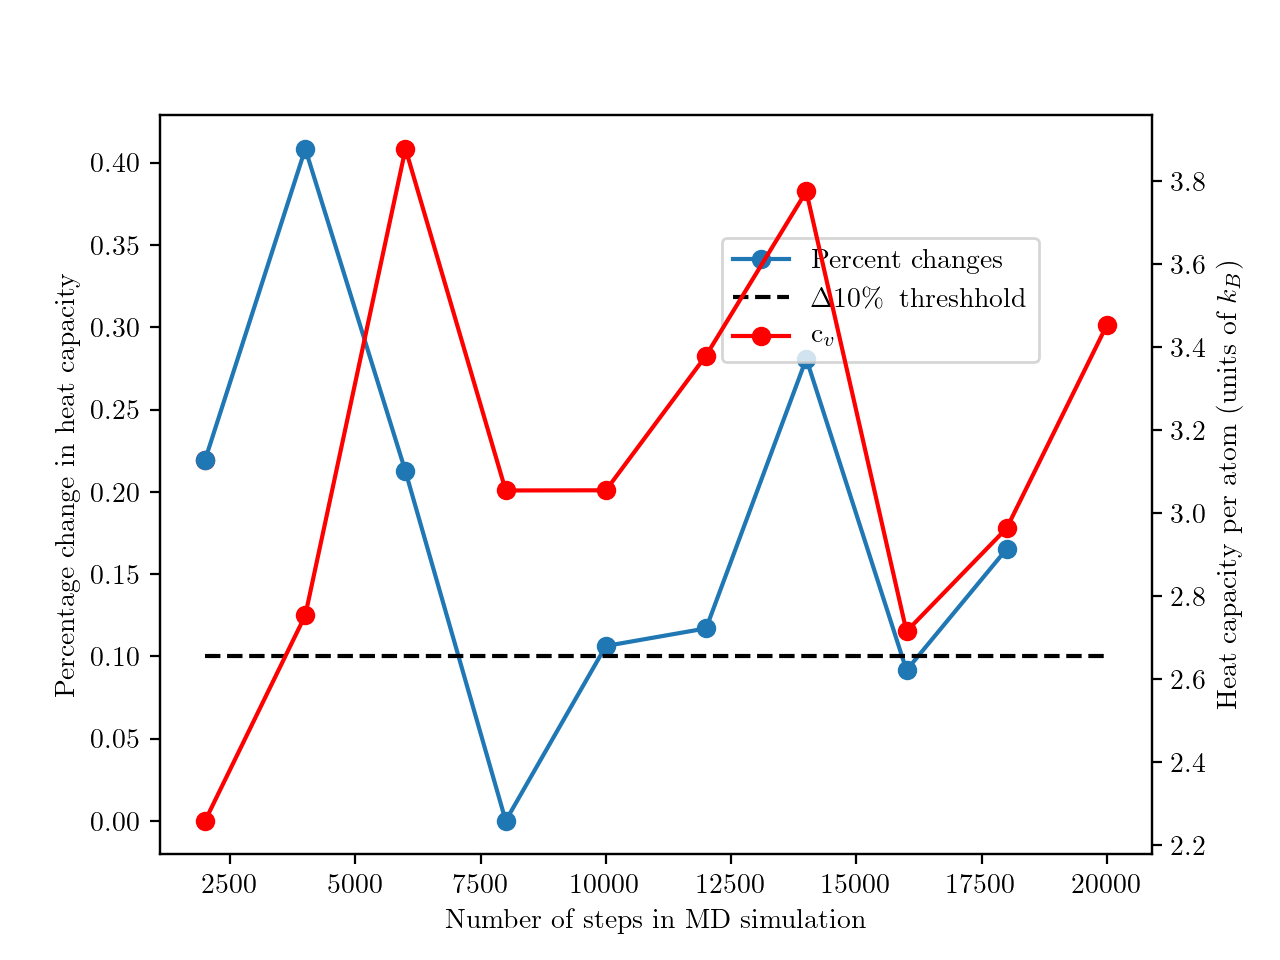

In [98]:
fig, ax = plt.subplots()
ax.plot(num_steps_list[:-1], np.abs(percent_changes), 'o-', label='Percent changes')
ax.plot(num_steps_list, np.ones(len(num_steps_list))*0.1,'--', 
        label=r'$\Delta 10\%\:$ threshhold', color='k')
ax.plot(num_steps_list[0], np.abs(percent_changes)[0], 'o-', color='red', 
        label=r'c_v', zorder=0) # Dummy for legend label

ax.set_xlabel("Number of steps in MD simulation")
ax.set_ylabel("Percentage change in heat capacity")

ax_twin = ax.twinx()
ax_twin.plot(num_steps_list, heat_caps_arr, 'o-', color='red', label=r'c_v')
ax_twin.set_ylabel(r"Heat capacity per atom (units of $k_B$)")

ax.legend(bbox_to_anchor=(.9, 0.75), loc='right')
plt.show()

Let's try running the simulation for longer...

In [99]:
heat_cap_MD_list_new = []

num_steps_list_new = np.arange(22000, 30001, 2000)
for num_steps_curr in num_steps_list_new:
    kb_T_inst, e_tot_inst_diff = main_MD_loop(N, L, M, a, r_c, num_steps=num_steps_curr, dt=dt)
    
    # Get rid of the non-equilibrium period at the start
    num_steps_to_eq = 500
    kb_T_inst_eq = kb_T_inst[num_steps_to_eq:]
    
    c_v = heat_capacity(kb_T_inst_eq, 4*L*M*N)
    heat_cap_MD_list_new.append(c_v)

heat_caps_arr_new = np.array(heat_cap_MD_list_new)
percent_changes_new = np.ediff1d(heat_caps_arr_new) / heat_caps_arr_new[:-1]

100%|██████████| 30000/30000 [04:42<00:00, 106.19it/s]


<IPython.core.display.Javascript object>


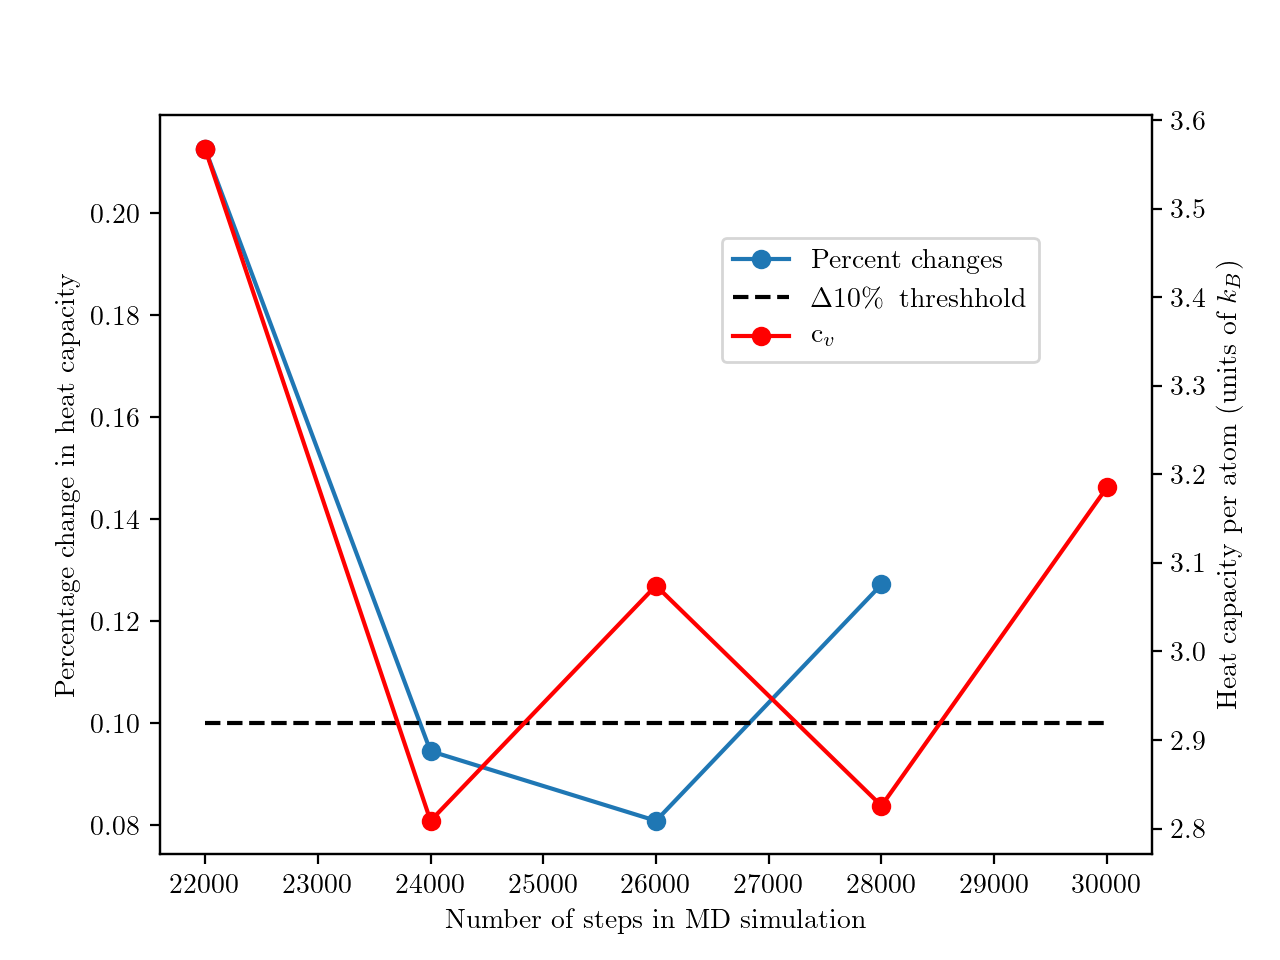

In [100]:
fig, ax = plt.subplots()
ax.plot(num_steps_list_new[:-1], np.abs(percent_changes_new), 'o-', label='Percent changes')
ax.plot(num_steps_list_new, np.ones(len(num_steps_list_new))*0.1,'--', 
        label=r'$\Delta 10\%\:$ threshhold', color='k')
ax.plot(num_steps_list_new[0], np.abs(percent_changes_new)[0], 'o-', color='red', 
        label=r'c_v', zorder=0) # Dummy for legend label

ax.set_xlabel("Number of steps in MD simulation")
ax.set_ylabel("Percentage change in heat capacity")

ax_twin = ax.twinx()
ax_twin.plot(num_steps_list_new, heat_caps_arr_new, 'o-', color='red', label=r'c_v')
ax_twin.set_ylabel(r"Heat capacity per atom (units of $k_B$)")

ax.legend(bbox_to_anchor=(.9, 0.75), loc='right')
plt.show()

<IPython.core.display.Javascript object>


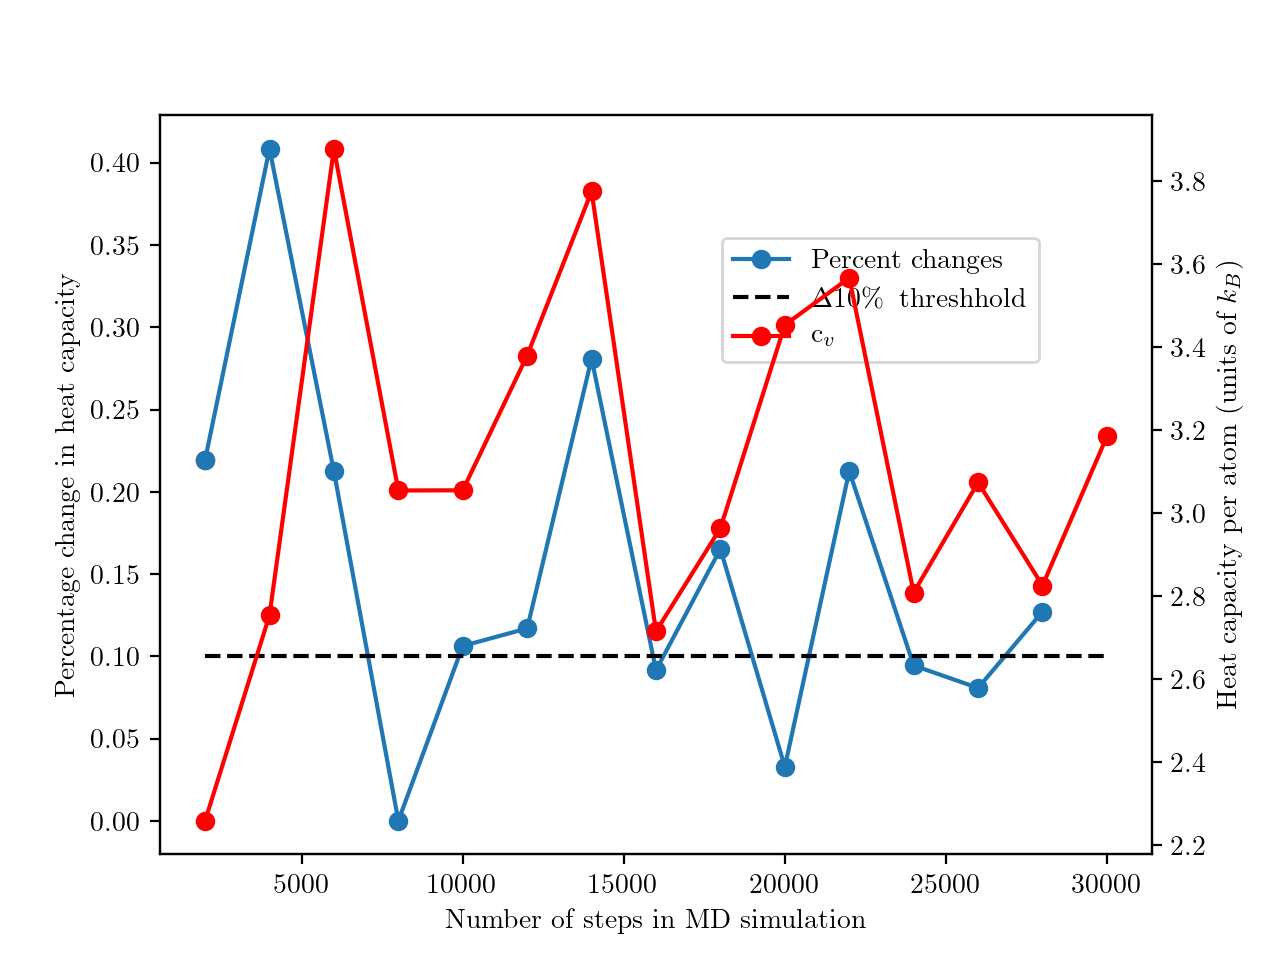

In [106]:
num_steps_list_concat   = np.append(num_steps_list, num_steps_list_new)
heat_caps_arr_concat = np.array(heat_cap_MD_list + heat_cap_MD_list_new)
percent_changes_concat  = np.ediff1d(heat_caps_arr_concat) / heat_caps_arr_concat[:-1]

fig, ax = plt.subplots()
ax.plot(num_steps_list_concat[:-1], np.abs(percent_changes_concat), 'o-', label='Percent changes')
ax.plot(num_steps_list_concat, np.ones(len(num_steps_list_concat))*0.1,'--', 
        label=r'$\Delta 10\%\:$ threshhold', color='k')
ax.plot(num_steps_list_concat[0], np.abs(percent_changes_concat)[0], 'o-', color='red', 
        label=r'c_v', zorder=0) # Dummy for legend label

ax.set_xlabel("Number of steps in MD simulation")
ax.set_ylabel("Percentage change in heat capacity")

ax_twin = ax.twinx()
ax_twin.plot(num_steps_list_concat, heat_caps_arr_concat, 'o-', color='red', label=r'c_v')
ax_twin.set_ylabel(r"Heat capacity per atom (units of $k_B$)")

ax.legend(bbox_to_anchor=(.9, 0.75), loc='right')
plt.show()

Let's try running an even longer simulation...

In [107]:
heat_cap_MD_list_new_new = []

num_steps_list_new_new = np.arange(32000, 40001, 2000)
for num_steps_curr in num_steps_list_new_new:
    kb_T_inst, e_tot_inst_diff = main_MD_loop(N, L, M, a, r_c, num_steps=num_steps_curr, dt=dt)
    
    # Get rid of the non-equilibrium period at the start
    num_steps_to_eq = 500
    kb_T_inst_eq = kb_T_inst[num_steps_to_eq:]
    
    c_v = heat_capacity(kb_T_inst_eq, 4*L*M*N)
    heat_cap_MD_list_new.append(c_v)

heat_caps_arr_new_new = np.array(heat_cap_MD_list_new_new)
percent_changes_new_new = np.ediff1d(heat_caps_arr_new_new) / heat_caps_arr_new_new[:-1]

100%|██████████| 40000/40000 [06:11<00:00, 107.78it/s]


<IPython.core.display.Javascript object>


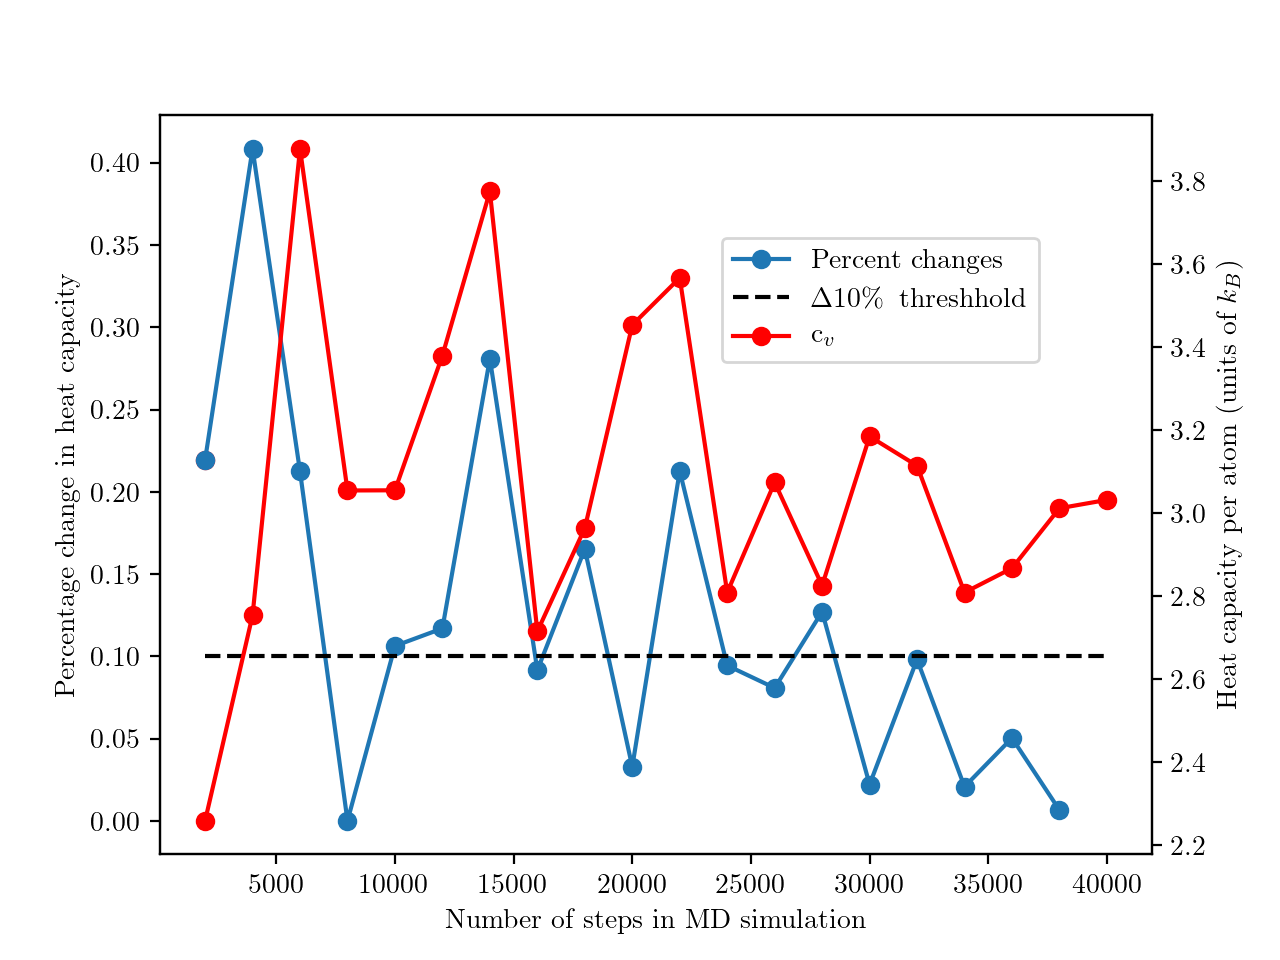

In [109]:
num_steps_list_concat   = np.append(num_steps_list, np.append(num_steps_list_new, num_steps_list_new_new))
heat_caps_arr_concat = np.array(heat_cap_MD_list + heat_cap_MD_list_new + heat_cap_MD_list_new_new)
percent_changes_concat  = np.ediff1d(heat_caps_arr_concat) / heat_caps_arr_concat[:-1]

fig, ax = plt.subplots()
ax.plot(num_steps_list_concat[:-1], np.abs(percent_changes_concat), 'o-', label='Percent changes')
ax.plot(num_steps_list_concat, np.ones(len(num_steps_list_concat))*0.1,'--', 
        label=r'$\Delta 10\%\:$ threshhold', color='k')
ax.plot(num_steps_list_concat[0], np.abs(percent_changes_concat)[0], 'o-', color='red', 
        label=r'c_v', zorder=0) # Dummy for legend label

ax.set_xlabel("Number of steps in MD simulation")
ax.set_ylabel("Percentage change in heat capacity")

ax_twin = ax.twinx()
ax_twin.plot(num_steps_list_concat, heat_caps_arr_concat, 'o-', color='red', label=r'c_v')
ax_twin.set_ylabel(r"Heat capacity per atom (units of $k_B$)")

ax.legend(bbox_to_anchor=(.9, 0.75), loc='right')
plt.show()

So we see that for **convergence to within 10%** using the velocity verlet MD simulation, we need close to **30,000 steps with $\Delta t = 0.01$, or about 300 LJ time units**.

## 1.1 (cont.)

Using the results of our simulation above, we can check at which point we achieved 10% accuracy of the target value for the classical heat capacity $c_v = 3\: k_B$. 

<IPython.core.display.Javascript object>


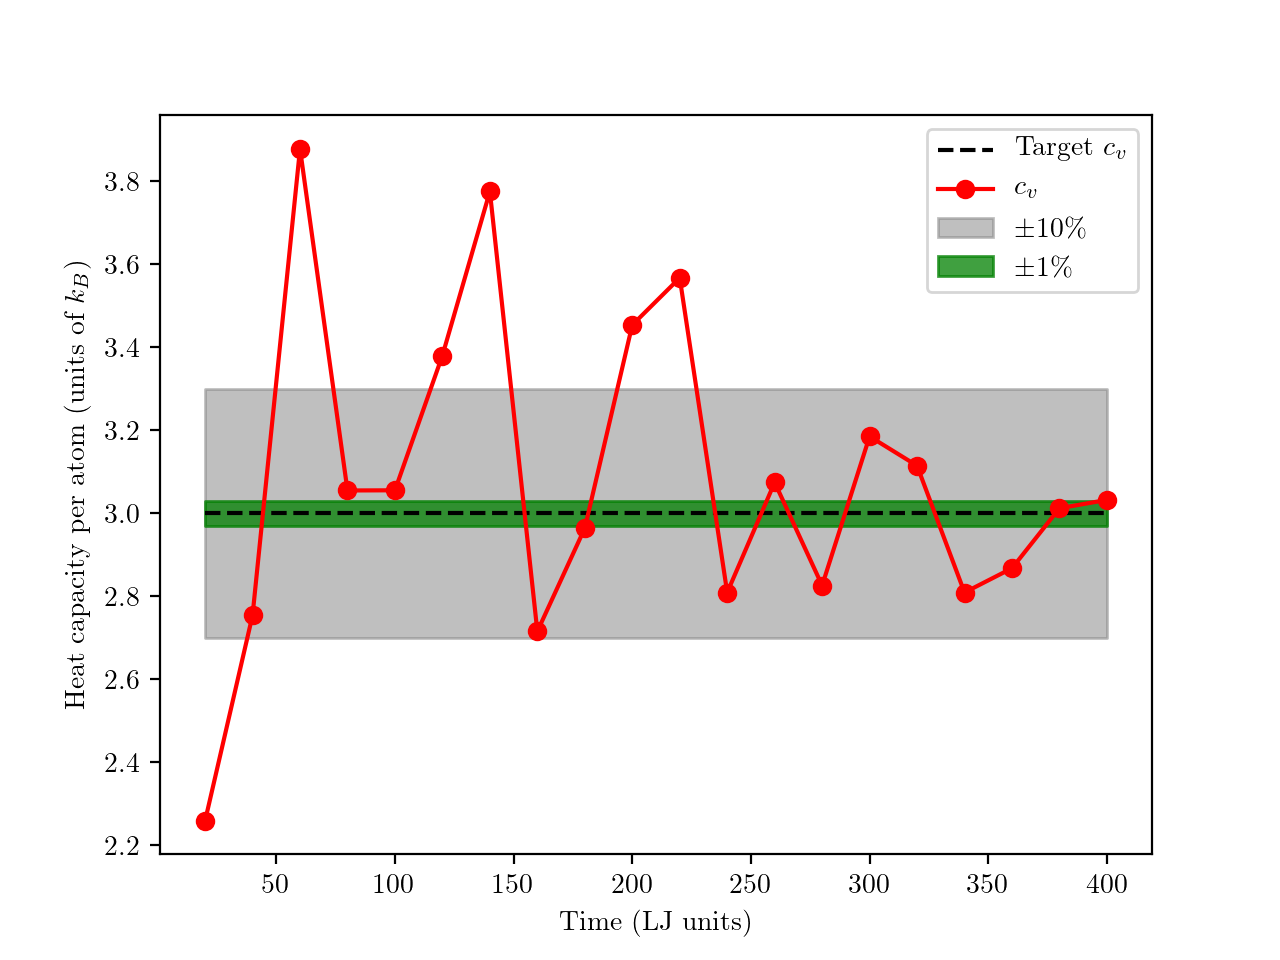

In [116]:
target_c_v = 3.0
t = num_steps_list_concat * dt

fig, ax = plt.subplots()
ax.plot(t, np.ones(t.shape[0])*target_c_v, 'k--', label=r'Target $c_v$')
ax.fill_between(t, target_c_v - target_c_v*0.1, target_c_v + target_c_v*0.1, alpha=0.5, 
                color='gray', label=r'$\pm 10\%$')
ax.fill_between(t, target_c_v - target_c_v*0.01, target_c_v + target_c_v*0.01, alpha=0.75, 
                color='green', label=r'$\pm 1\%$')
ax.plot(t, heat_caps_arr_concat, 'ro-', label=r'$c_v$')
ax.set_ylabel(r"Heat capacity per atom (units of $k_B$)")
ax.set_xlabel(r"Time (LJ units)")
ax.legend()
plt.show()

So we see that you only need about **240 LJ time units** (24,000 iterations at $\Delta t = 0.01$) to achieve a **reproducible result to within 10% accuracy** of the classical heat capacity per atom for the perfectly harmonic crystal.

## 1.2

Let's attempt to explain some sources of bias in our simulation's estimate of the heat capacity per atom compared to the classical result for a perfectly harmonic crystal where $c_v = 3 \: k_b$.

In our MD simulation, we are not assuming the crystal is perfectly harmonic, because our LJ potential is not quadratic. A quadratic nuclear potential would imply that we are in the perfect harmonic crystal case. This is a discrepancy in assumptions between our simulation's estimate of the heat capacity via thermal fluctuations and the classical $c_v = 3 \: k_b$ result.

From problem set 3, question 5, we saw that in this type of (classical) MD simulation, we don't account for quantum nuclear effects even though $\hbar \omega_\mathrm{max}$ is of the same order of magnitude as $k_b T$, where $\hbar \omega_\mathrm{max}$ is the energy of the maximum vibrational frequency. This means that quantum nuclear effects should impact the simulation dynamics, but we've left them out in our analysis thus far.

## 1.3

Now we'll turn the initial temperature up to $k_b T = 4.0$ to analyze the thermal fluctuations of the liquid crystal.

In [63]:
a = 2**(2.0/3.0)
r_c = 1.3
dt = 0.01
num_steps = 20000
equilibrium_time = 5.0

N = 3
L = 3
M = 3
print("N, L, M = {}".format(N))
kb_T_inst, e_tot_inst_diff = main_MD_loop(N, L, M, a, r_c, kb_T=4.0, num_steps=num_steps, dt=dt)

# Get rid of the equilibration period
num_steps_to_eq = int(equilibrium_time/dt)
kb_T_inst_eq = kb_T_inst[num_steps_to_eq:]

  0%|          | 0/20000 [00:00<?, ?it/s]

N, L, M = 3


100%|██████████| 20000/20000 [3:19:46<00:00,  1.67it/s]


<IPython.core.display.Javascript object>


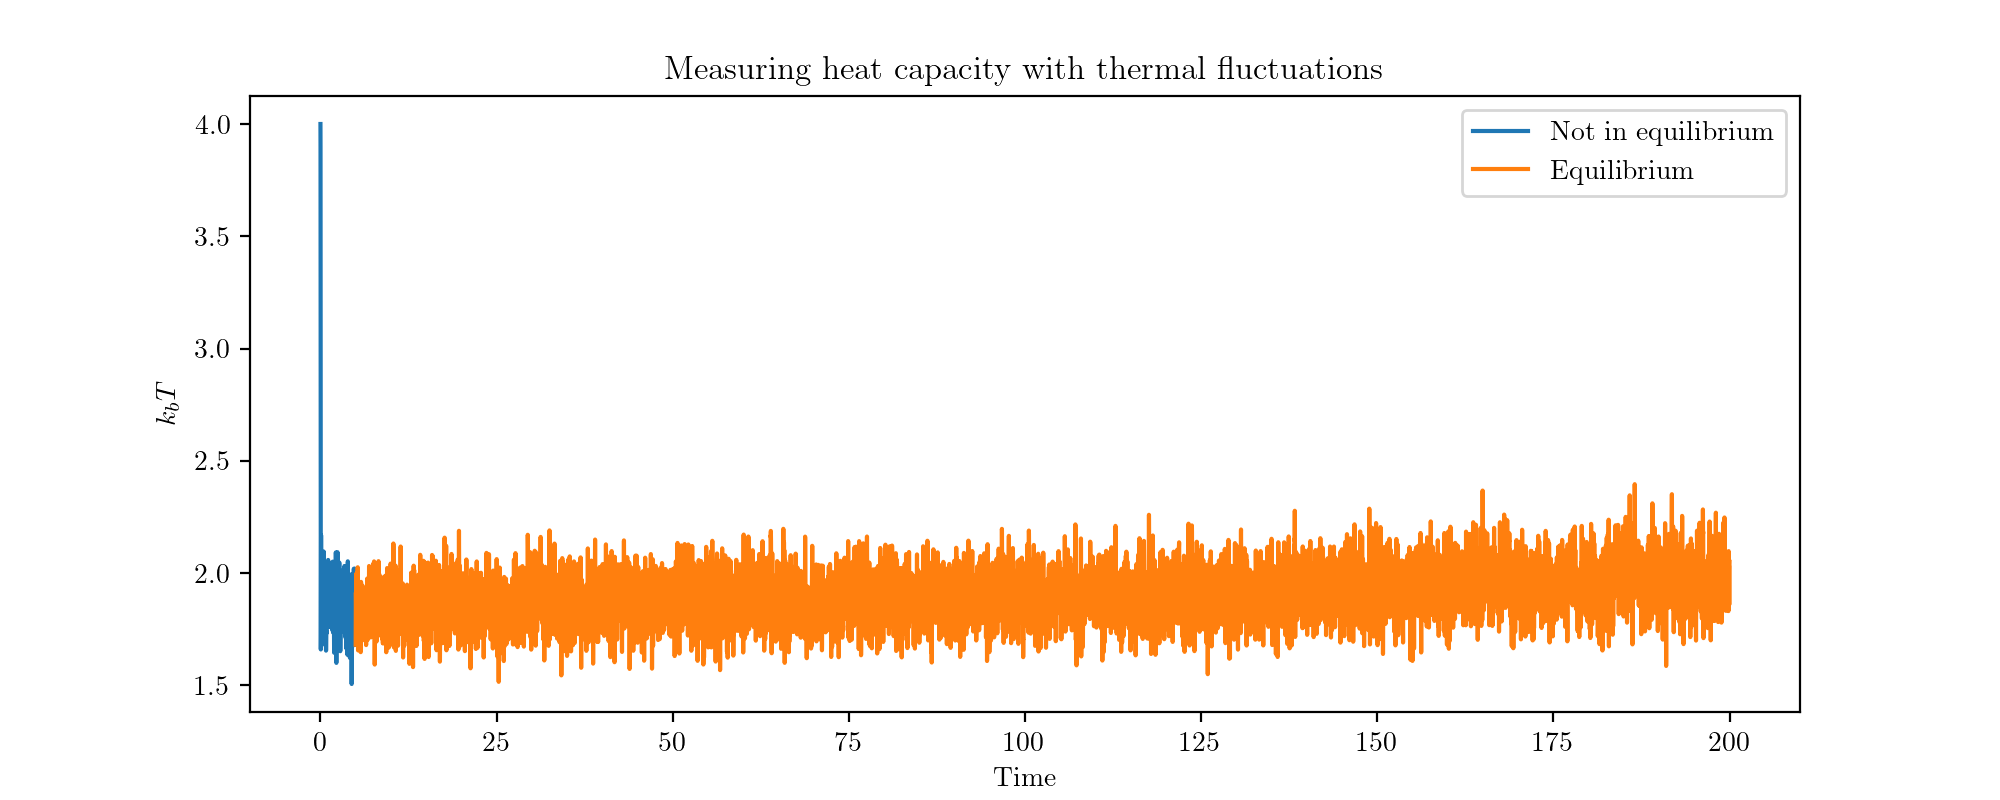

Heat capacity per atom: 3.08390 (units of k_b)


In [64]:
fig, ax = plt.subplots(figsize=(10, 4))
t = np.arange(num_steps+1)*dt
ax.plot(t[0:num_steps_to_eq], kb_T_inst[0:num_steps_to_eq], label="Not in equilibrium")
ax.plot(t[num_steps_to_eq:], kb_T_inst_eq, label='Equilibrium')

ax.set_title("Measuring heat capacity with thermal fluctuations")
ax.set_ylabel(r"$k_b T$")
ax.set_xlabel("Time")
ax.legend()
plt.show()

c_v = heat_capacity(kb_T_inst_eq, 4*L*M*N)
print("Heat capacity per atom: {:.5f} (units of k_b)".format(c_v))

We find that the heat capacity per atom for the liquid case (i.e. $k_b T(t = 0) = 4.0$) is roughly the same as for the solid lattice.

# 2. Monte carlo generation of ensemble averages

In [3]:
def MC_MD_loop(N, L, M, a, r_c, kb_T=0.1, delta=0.1, num_steps=10000):
    '''
    Used this initially and it works, but it's just a lot slower than MC_MD_loop_fast() below.
        This function runs at about 90 iters/sec, while _fast() can do 3000 iters/sec.
    
    Note that this function and MC_MD_loop_fast() return different things (num_accepted vs rejection_ratio)
    '''
    
    # Initialization
    atoms_t, latvec_mat = setup_cell(L, M, N, a=a)
    num_atoms, dimensions = atoms_t.shape
    e_pot_t, foo = calc_energy_and_forces(atoms_t, latvec_mat, r_c, calc_forces=False)
    
    # Number of accepted steps
    num_accepted = 0
    
    # Will return a time series of the potential energies. 
    # Right off the bat, we don't know how long the "time series" will be depending on how many steps we reject
    e_pot_time_series = []
    e_pot_time_series.append(e_pot_t)
    
    for i in tqdm(range(num_steps)):
        
        # Pick an atom randomly
        j = np.random.randint(num_atoms)
        atoms_j_old = np.copy(atoms_t[j])
        
        # Generate random displacement
        delta_r = np.random.rand(dimensions)
        disp_vec = delta * (delta_r - 0.5)
        disp_vec_norm = np.linalg.norm(disp_vec) / (np.sqrt(dimensions) * delta)
        atoms_t[j] += disp_vec
        
        # Calculate the new energy of the crystal
        e_pot_t_plus_1, foo = calc_energy_and_forces(atoms_t, latvec_mat, r_c)
        boltzmann_factor = np.exp(-1* (1/(kb_T)) * (e_pot_t_plus_1 - e_pot_t))
        
        if e_pot_t_plus_1 < e_pot_t or disp_vec_norm < boltzmann_factor:
            e_pot_time_series.append(e_pot_t_plus_1)
            e_pot_t = e_pot_t_plus_1
            num_accepted  += 1
        else:
            # Reject the step and return to old state
            atoms_t[j] = atoms_j_old

    return np.array(e_pot_time_series), num_accepted

In [353]:
def MC_MD_loop_fast(N, L, M, a, r_c, 
                    kb_T=0.1, delta=0.1, num_steps=10000, annealing_schedule=None, 
                    return_pos_time_series=False, latvec_double=False, return_step_sequence=False):
    '''
    This MC function makes use of the vectorized delta_energy_single_atom_disp(), which calculates the change in 
    the potential energy of the crystal due to the shift of a single atom without using any loops.
    
    This version is pretty fast, giving us about 3000 iterations/second.
    
    Annealing schedule should be np.array() of length num_steps if not None.
    '''
    
    # Initialization
    atoms_t, latvec_mat = setup_cell(L, M, N, a=a)
    
    # Problem 4.5
    if latvec_double:
        latvec_mat *= 2
    
    num_atoms, dimensions = atoms_t.shape
    e_pot_t, foo = calc_energy_and_forces(atoms_t, latvec_mat, r_c, calc_forces=False)
    
    # Number of accepted steps
    num_accepted = 0
    
    # Will return a time series of the potential energies. 
    # Right off the bat, we don't know how long the "time series" will be depending on how many steps we reject
    e_pot_time_series = []
    e_pot_time_series.append(e_pot_t)
    
    # If no annealing, the temperature is just constant throughout the simulation.
    if annealing_schedule is None:
        annealing_schedule = kb_T * np.ones(num_steps)
        
    # If we're asked to return a time-series of the position
    pos_time_series = np.zeros((atoms_t.shape[0], atoms_t.shape[1], 1))
    if return_pos_time_series:
        pos_time_series[:, :, 0] = atoms_t
        
    # If we're asked to keep track of the sequence of steps we take
    step_sequence = np.zeros(num_steps)
    
    for i in tqdm(range(num_steps)):
        
        # Pick an atom randomly
        j = np.random.randint(num_atoms)
        atoms_j_old = np.copy(atoms_t[j])
        
        # Generate random displacement
        delta_r = np.random.rand(dimensions)
        disp_vec = delta * (delta_r - 0.5)
        disp_vec_norm = np.linalg.norm(disp_vec) / (np.sqrt(dimensions) * delta)
        atoms_t[j] += disp_vec
        
        # Calculate the new energy of the crystal
        e_delta = delta_energy_single_atom_disp(atoms_t, latvec_mat, r_c, j, disp_vec)
        e_pot_t_plus_1 = e_pot_t + e_delta
        
        kb_T = annealing_schedule[i]
        boltzmann_factor = np.exp(-1* (1/(kb_T)) * (e_pot_t_plus_1 - e_pot_t))
        
        if e_pot_t_plus_1 < e_pot_t or disp_vec_norm < boltzmann_factor:
            e_pot_time_series.append(e_pot_t_plus_1)
            e_pot_t = e_pot_t_plus_1
            
            if return_pos_time_series:
                pos_time_series = np.append(pos_time_series, np.expand_dims(atoms_t, 2), axis=2)
            if return_step_sequence:
                step_sequence[i] = 1
            
        else:
            # Reject the step and return to old state
            atoms_t[j] = atoms_j_old
    
    reject_ratio = (num_steps - len(e_pot_time_series)) / num_steps
    
    if return_pos_time_series:
        return np.array(e_pot_time_series), reject_ratio, pos_time_series
    
    if return_step_sequence:
        return np.array(e_pot_time_series), reject_ratio, step_sequence
    
    return np.array(e_pot_time_series), reject_ratio

## 2.1

In [22]:
a = 2**(2.0/3.0)
r_c = 1.3
N = 2
L = 2
M = 2
num_steps = 10000
e_pot_time_series_MC, rejection_ratio = MC_MD_loop_fast(N, L, M, a, r_c, num_steps = num_steps)

print("N, L, M = {}".format(N))

100%|██████████| 10000/10000 [00:03<00:00, 2783.15it/s]

N, L, M = 2


In [24]:
print("Rejection rate: {:.4f}".format(rejection_ratio))

Rejection rate: 0.6740


<IPython.core.display.Javascript object>


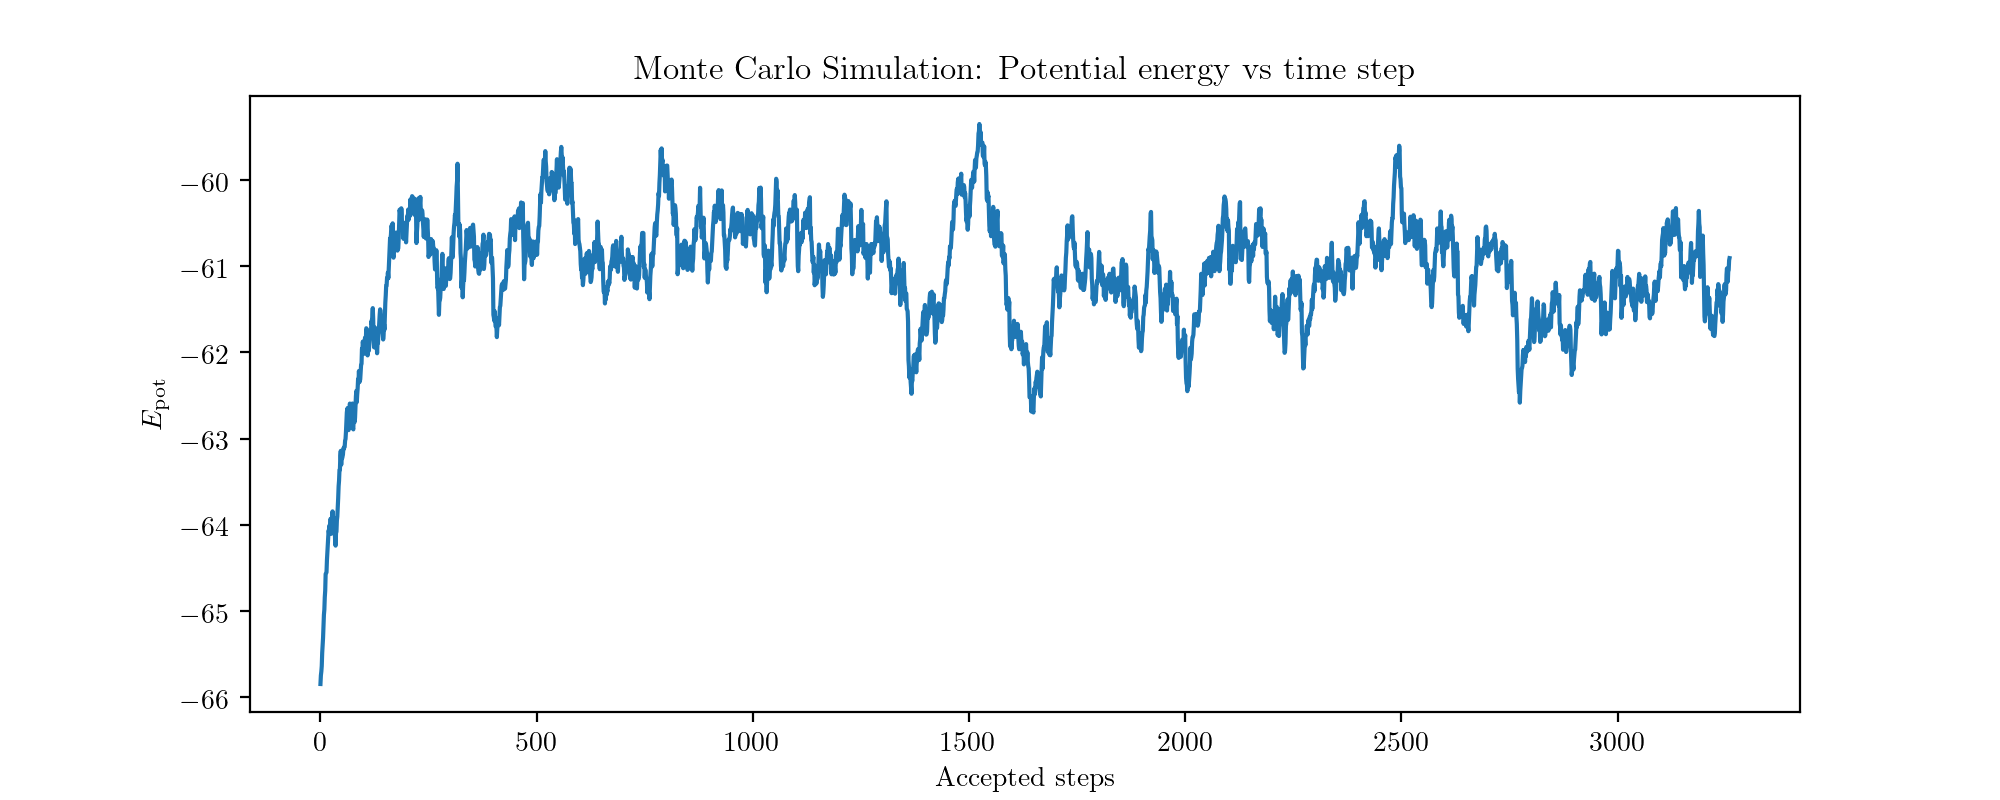

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(np.arange(len(e_pot_time_series_MC)), np.array(e_pot_time_series_MC))

ax.set_title("Monte Carlo Simulation: Potential energy vs time step")
ax.set_ylabel(r"$E_\mathrm{pot}$")
ax.set_xlabel("Accepted steps")
ax.legend()
plt.show()

So we see that for **10,000 (total) steps in the Monte Carlo simulation, about $67 \%$ of the steps are rejected**, leading to about 3000 actual accepted steps. The potential energy of the crystal fluctuates as seen above. Note that there is an equilibration period of about 500 accepted steps to start. Moving forward, we'll clip the first 500 accepted steps before calculating physical quantities with the simulation.

## 2.2

Let's compare the Monte Carlo simulation to our original MD simulation, using velocity verlet integration for the time evolution. To make the comparison fair, let's time-evolve the MD simulation for about the same number of accepted steps for the MC trial above (i.e. about 3000 steps).

In [26]:
a = 2**(2.0/3.0)
r_c = 1.3
dt = 0.01

equilibrium_time = 5.0
num_steps = 3000

N = 2
L = 2
M = 2

# nb: The default kb_T value for main_MD_loop() is kb_T = 0.2
kb_T_inst, e_tot_inst_diff, e_pot_time_series_MD = main_MD_loop(N, L, M, a, r_c, num_steps=num_steps, 
                                                             dt=dt, return_e_pot=True)
print("N, L, M = {}".format(N))

100%|██████████| 3000/3000 [00:34<00:00, 87.51it/s]

N, L, M = 2


<IPython.core.display.Javascript object>


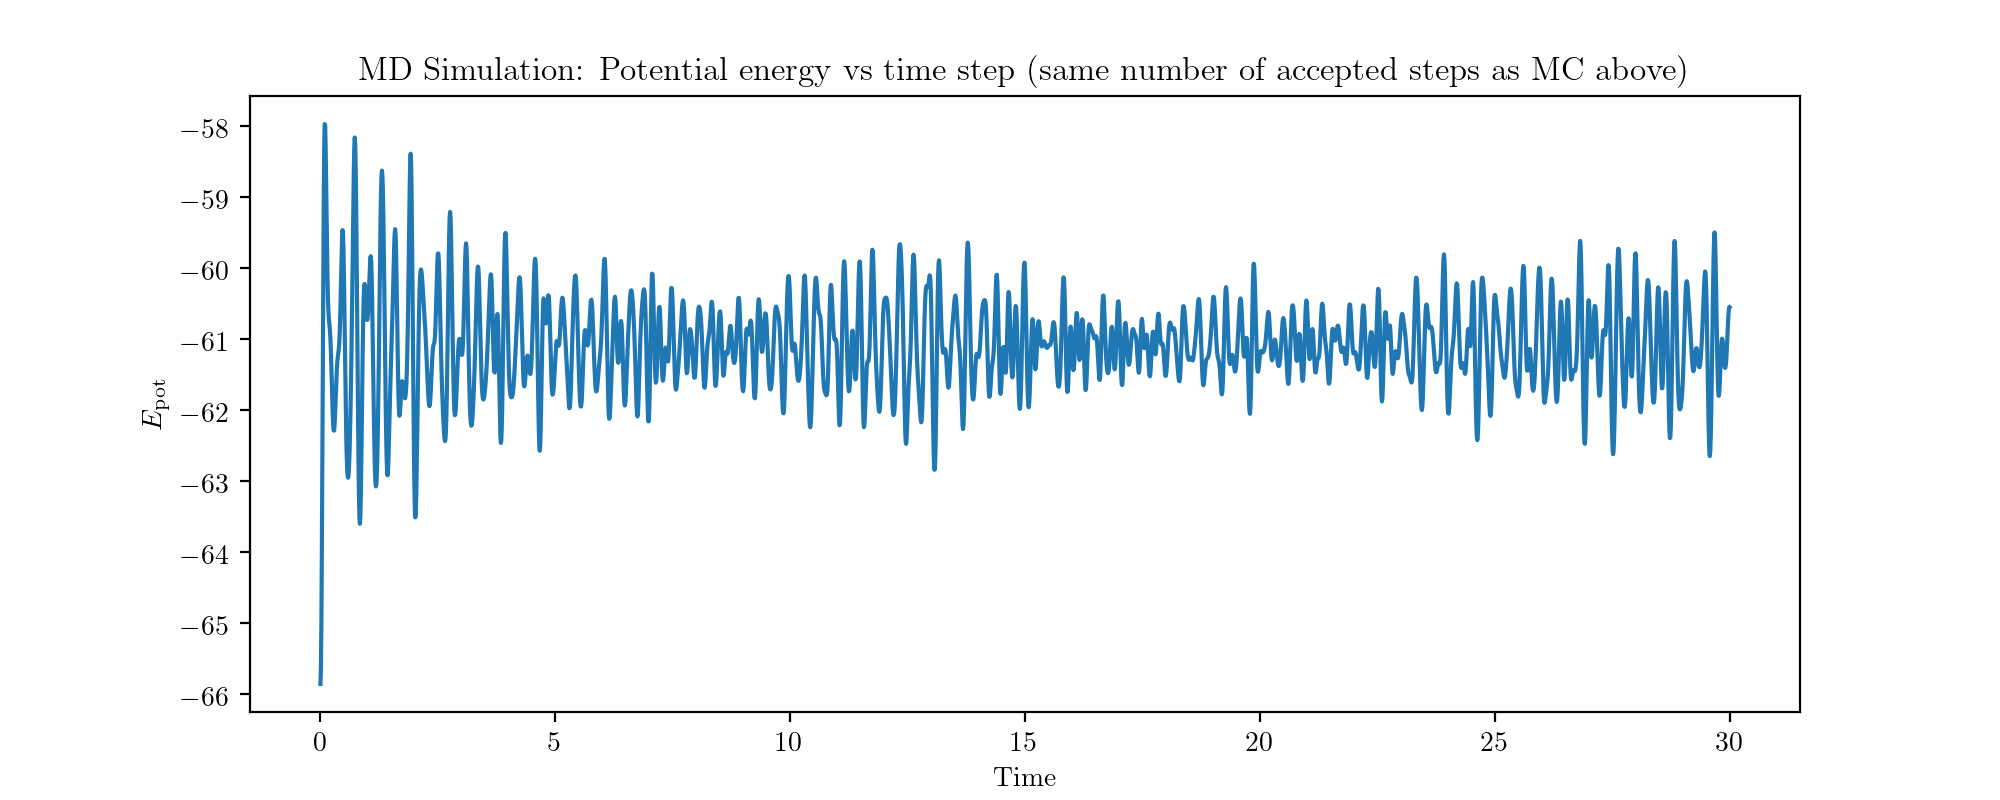

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(np.arange(len(e_pot_time_series_MD))*dt, np.array(e_pot_time_series_MD))

ax.set_title("MD Simulation: Potential energy vs time step (same number of accepted steps as MC above)")
ax.set_ylabel(r"$E_\mathrm{pot}$")
ax.set_xlabel("Time")
ax.legend()
plt.show()

To compare the two simulations, let's first cut off the equilibrium period at the start of the two time-series. Previously, we've used an equilibrium time of 5.0s. To translate this into (accepted) steps for the Monte Carlo simulation, we'll just cut off the front end of the time series by a proportional amount to the MD simulation (since they both use the same number of overall steps, this is equivalent to excluding the first 500 steps from each). Recall also that 500 accepted steps was our ballpark estimate of the equilibriation period for the MC simulation when we first ran it in part 2.1.

In [29]:
# Get rid of the part of the time-series when the crystal is not in equilibrium
equilibrium_time = 5.0

# Get rid of the equilibration period
num_steps_to_eq = int(equilibrium_time/dt)
e_pot_time_series_MC_eq = e_pot_time_series_MC[num_steps_to_eq:]
e_pot_time_series_MD_eq = e_pot_time_series_MD[num_steps_to_eq:]

In [30]:
# Now calculate the average potential energy from both simulations
e_pot_MC_avg = np.mean(e_pot_time_series_MC_eq)
e_pot_MD_avg = np.mean(e_pot_time_series_MD_eq)

# Calculate the standard deviation of the (equilibrium) time-series as a measure of the magnitude of the fluctuations
e_pot_MC_stdv = np.sqrt(np.var(e_pot_time_series_MC_eq))
e_pot_MD_stdv = np.sqrt(np.var(e_pot_time_series_MD_eq))

print("Monte Carlo E_pot average and standard deviation:   {:.5f}, {:.5f} (both in units of epsilon)"\
      .format(e_pot_MC_avg, e_pot_MC_stdv))
print("MD Simulation E_pot average and standard deviation: {:.5f}, {:.5f} (both in units of epsilon)"\
      .format(e_pot_MD_avg, e_pot_MD_stdv))

Monte Carlo E_pot average and standard deviation:   -61.00739, 0.55446 (both in units of epsilon)
MD Simulation E_pot average and standard deviation: -61.06850, 0.52801 (both in units of epsilon)


So we see that the **Monte Carlo and MD simulations return about the same results for the average potential energy of the crystal**, which is encouraging. The MC simulation has a slightly higher standard deviation (which we'll use here as a measure of the magnitude of the fluctuations) for the potential energy time-series.

## 2.3

Let's now try MC with different displacement step sizes (different values of $\Delta$), and try to aim for an acceptance rate of $50 \%$.

In [31]:
a = 2**(2.0/3.0)
r_c = 1.3
N = 2
L = 2
M = 2
num_steps = 50000
delta = 0.0725      # Will give us a rejection ratio of about 50%?

e_pot_time_series_MC, rejection_ratio = MC_MD_loop_fast(N, L, M, a, r_c, delta = delta, num_steps = num_steps)
print("N, L, M = {}".format(N))
print("Delta = {}, rejection ratio = {:.4f}".format(delta, rejection_ratio))

# Clip the simulation's first 500 iterations, corresponding to the equilibrium period.
num_steps_to_eq = 500 # Can tweak this based on the plot below
e_pot_time_series_MC_eq = e_pot_time_series_MC[num_steps_to_eq:]

100%|██████████| 50000/50000 [00:16<00:00, 3053.76it/s]

N, L, M = 2
Delta = 0.0725, rejection ratio = 0.5087


After some experimentation, we find that **by using $\Delta = 0.0725$, we get a rejection ratio of about 50%**. Moving forward, we'll use $\Delta = 0.0725$ since it offers a good balance between simulation accuracy and efficiency. 

# 3. Heat capacity from MC

## 3.1

From the problem set statement, equation 4, we have $$\langle E_\mathrm{pot}^2 \rangle - \langle E_\mathrm{pot} \rangle^2 = N k_b T^2 (c_v - \frac{3}{2}k_b),$$ which is equivalent to $$\frac{\sigma_{E_\mathrm{pot}}^2}{N (k_b T)^2} + \frac{3}{2} = \frac{c_v}{k_b}.$$ The second form of the equation is more useful for us in our calculation of the heat capacity, because it returns a result in units of $k_b$, and accepts an argument as $k_b T$, which we set ourselves as $k_b T = 0.1$.

In [32]:
a = 2**(2.0/3.0)
r_c = 1.3
N = 2
L = 2
M = 2
num_steps = 50000
delta = 0.0725      # Will give us a rejection ratio of about 50%

e_pot_time_series_MC, rejection_ratio = MC_MD_loop_fast(N, L, M, a, r_c, delta = delta, num_steps = num_steps)

print("N, L, M = {}".format(N))
print("Delta = {}, rejection ratio = {:.4f}".format(delta, rejection_ratio))

# Clip the simulation's first 500 iterations, corresponding to the equilibrium period.
num_steps_to_eq = 500 # Can tweak this based on the plot below
e_pot_time_series_MC_eq = e_pot_time_series_MC[num_steps_to_eq:]

100%|██████████| 50000/50000 [00:15<00:00, 3155.21it/s]


N, L, M = 2
Delta = 0.0725, rejection ratio = 0.5079


<IPython.core.display.Javascript object>


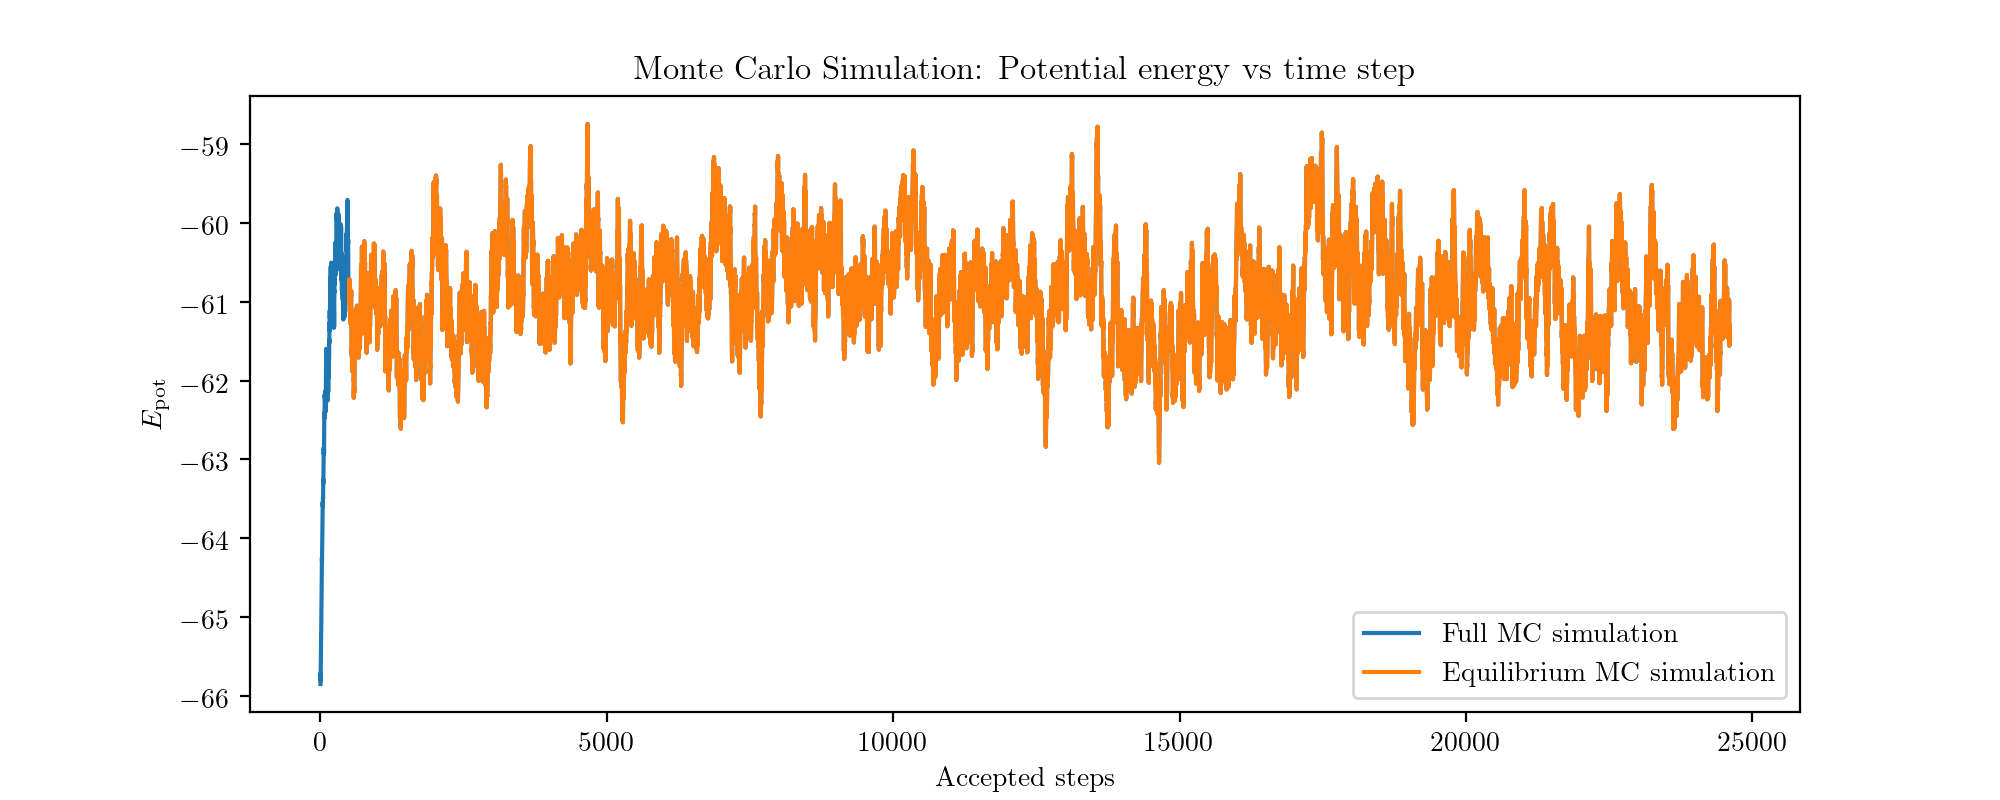

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))
steps = np.arange(len(e_pot_time_series_MC))
ax.plot(steps, e_pot_time_series_MC, label='Full MC simulation')
ax.plot(steps[num_steps_to_eq:], e_pot_time_series_MC_eq, label='Equilibrium MC simulation')

ax.set_title("Monte Carlo Simulation: Potential energy vs time step")
ax.set_ylabel(r"$E_\mathrm{pot}$")
ax.set_xlabel("Accepted steps")
ax.legend()
plt.show()

So it looks reasonable that we cut the first 500 steps to reach equilibrium.

In [34]:
kb_T = 0.1
num_atoms = 4*N*L*M
c_v = heat_capacity_MC(e_pot_time_series_MC_eq, kb_T, num_atoms)
print("Heat capacity per atom from MC simulation = {:.4f} (units of kb)".format(c_v))

Heat capacity per atom from MC simulation = 2.7390 (units of kb)


So we see that the **MC simulation gives us a measurement of the heat capacity of $c_v \approx 2.74 k_B$**. Now we'll try different values of the number of steps for the simulation to check for convergence.

In [63]:
a = 2**(2.0/3.0)
r_c = 1.3
N = 2
L = 2
M = 2
delta = 0.0725      # Will give us a rejection ratio of about 50%
kb_T = 0.1
num_atoms = 4*N*L*M

heat_cap_MC_list = []
num_accepted_steps_list = []

num_steps_list = np.arange(20000, 100001, 10000)
for num_steps_curr in num_steps_list:
    e_pot_time_series_MC, rejection_ration = MC_MD_loop_fast(N, L, M, a, r_c, 
                                                             delta = delta, kb_T = kb_T, num_steps = num_steps_curr)
    
    # Clip the simulation's first 500 iterations, corresponding to the equilibrium period.
    num_steps_to_eq = 500
    e_pot_time_series_MC_eq = e_pot_time_series_MC[num_steps_to_eq:]
    
    # Number of accepted steps (after cutting out equilibration period at start)
    num_accepted_steps_list.append(e_pot_time_series_MC_eq.shape[0])
    
    c_v = heat_capacity_MC(e_pot_time_series_MC_eq, kb_T, num_atoms)
    heat_cap_MC_list.append(c_v)

heat_caps_arr = np.array(heat_cap_MC_list)
percent_changes = np.ediff1d(heat_caps_arr) / heat_caps_arr[:-1]

100%|██████████| 100000/100000 [00:32<00:00, 3091.80it/s]


<IPython.core.display.Javascript object>


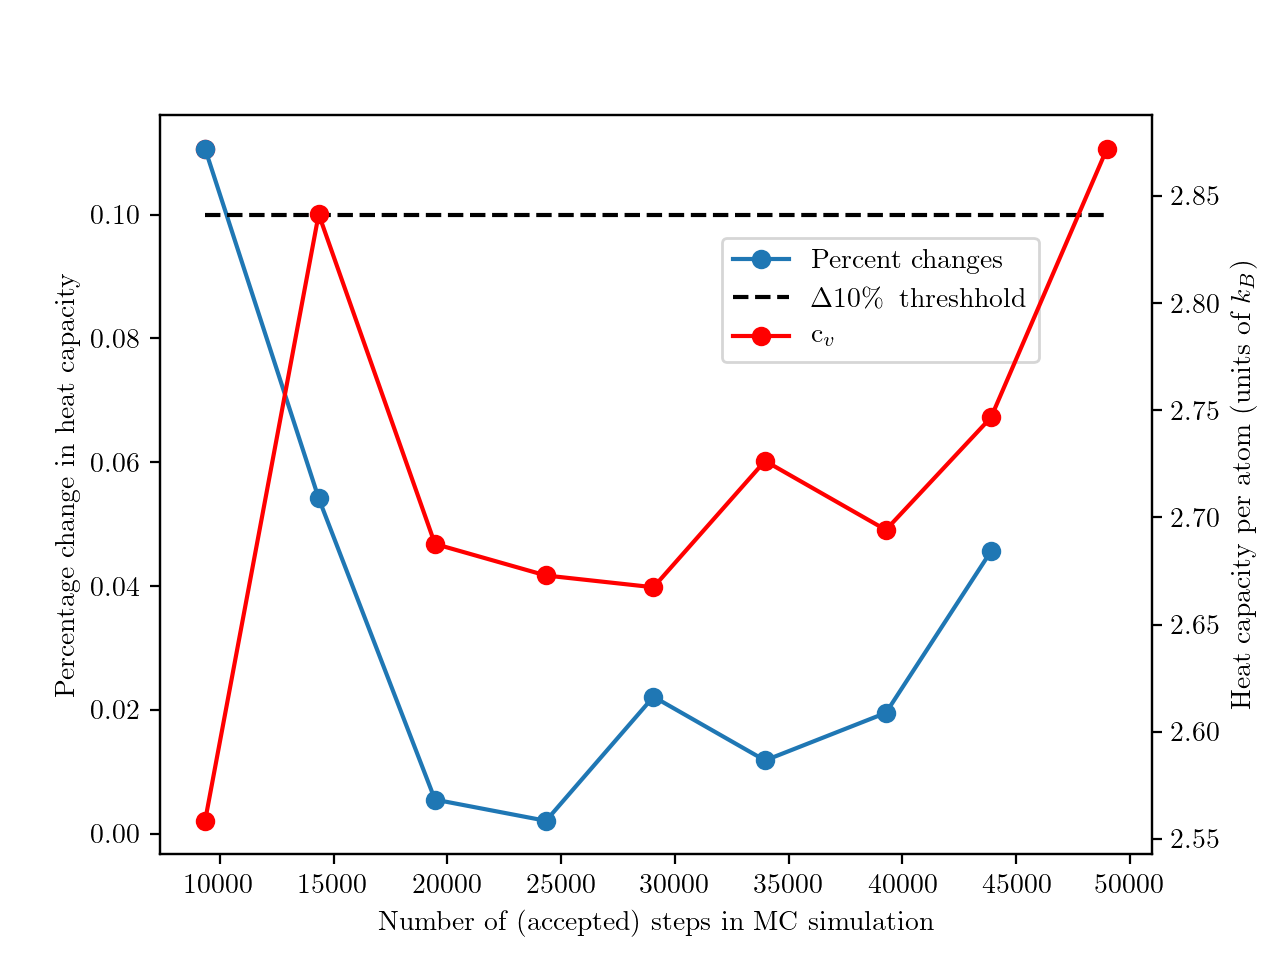

In [85]:
fig, ax = plt.subplots()
ax.plot(num_accepted_steps_list[:-1], np.abs(percent_changes), 'o-', label='Percent changes')
ax.plot(num_accepted_steps_list, np.ones(len(num_accepted_steps_list))*0.1,'--', 
        label=r'$\Delta 10\%\:$ threshhold', color='k')
ax.plot(num_accepted_steps_list[0], np.abs(percent_changes)[0], 'o-', color='red', 
        label=r'c_v', zorder=0) # Dummy for legend label

ax.set_xlabel("Number of (accepted) steps in MC simulation")
ax.set_ylabel("Percentage change in heat capacity")

ax_twin = ax.twinx()
ax_twin.plot(num_accepted_steps_list, heat_caps_arr, 'o-', color='red', label=r'c_v')
ax_twin.set_ylabel(r"Heat capacity per atom (units of $k_B$)")

ax.legend(bbox_to_anchor=(.9, 0.75), loc='right')
plt.show()

So we see that **it takes around 20,000 (accepted) MC steps to reach at least 10% convergence for our calculation of the heat capacity**, which we see comes out to be around the same value we saw earlier i.e. in part 2.1, where we found $c_v \approx 2.74 \: k_B$. Note here that the x-axis above is **accepted** steps, not the number of total iterations we told the MC simulation to run for. We're using $\Delta = 0.0725$ which we saw gives us a rejection rate of about 50%, so this means that the reach convergence on our value of $c_v$ (i.e. 20,000 accepted steps), we need to initialize the MC simulation with about 40,000 total iterations. Also note that for every simulation we chop off the first 500 accepted steps to allow for equilibration of the simulation.

## 3.2

In [87]:
print("Heat capacity per atom mean: {:.4f} (units of kB)".format(heat_caps_arr[-1]))
print("Simulation used N, L, M = {}, and had {} accepted MC steps.".format(N, num_accepted_steps_list[-1]))

Heat capacity per atom mean: 2.8720 (units of kB)
Simulation used N, L, M = 2, and had 48987 accepted MC steps.


Using the value for the heat capacity per atom measured from the MC simulation intialized with 100,000 total steps (about 48,987 accepted steps) we see that $c_v \approx 2.87 \: k_B$. This is slightly smaller than the classical value of $c_v = 3 \: k_B$ from our earlier discussion, but within 10%. It's also consistent with our measurement of the heat capacity per atom from the velocity verlet simulation. To double check our heat capacity measurement, let's just run the MC simulation for a very large number of total steps and see what value we get:

In [88]:
a = 2**(2.0/3.0)
r_c = 1.3
N = 2
L = 2
M = 2
num_steps = 200000
delta = 0.0725      # Will give us a rejection ratio of about 50%

e_pot_time_series_MC, rejection_ratio = MC_MD_loop_fast(N, L, M, a, r_c, delta = delta, num_steps = num_steps)

print("N, L, M = {}".format(N))
print("Delta = {}, rejection ratio = {:.4f}".format(delta, rejection_ratio))

# Clip the simulation's first 500 iterations, corresponding to the equilibrium period.
num_steps_to_eq = 500 # Can tweak this based on the plot below
e_pot_time_series_MC_eq = e_pot_time_series_MC[num_steps_to_eq:]

kb_T = 0.1
num_atoms = 4*N*L*M
c_v = heat_capacity_MC(e_pot_time_series_MC_eq, kb_T, num_atoms)
print("Heat capacity per atom from MC simulation = {:.4f} (units of kb)".format(c_v))

100%|██████████| 200000/200000 [01:09<00:00, 2875.20it/s]

N, L, M = 2
Delta = 0.0725, rejection ratio = 0.5051
Heat capacity per atom from MC simulation = 2.7853 (units of kb)


So we find that $c_v = 2.79\: k_B$ for something like 100,000 accepted steps. Again, this is a slightly smaller heat capacity per atom than what we found using the velocity verlet MD simulation (around $2.85 \: k_B$), but it's still pretty close.

# 4. Monte Carlo and the quest for the global minimum

## 4.1

In [230]:
a = (2**(2.0/3.0)) * 1.1 # Increase by 10%
r_c = 1.3
N = 3
L = 3
M = 3
num_steps = 4000
delta = 0.28 # Tune this to give ~50% rejection rate

# Annealing schedule initialization
kb_T_i = 2.0
kb_T_f = 1e-2 # Avoid divide by zero and/or overflow in np.exp() errors
annealing_schedule = np.linspace(kb_T_i, kb_T_f, num_steps) # Linear ramp down

e_pot_time_series_MC, rejection_ratio = MC_MD_loop_fast(N, L, M, a, r_c, delta=delta, 
                                                        num_steps=num_steps, annealing_schedule=annealing_schedule)

print("N, L, M = {}".format(N))
print("Delta = {}, rejection ratio = {:.4f}, total accepted steps = {}.".format(delta, 
                                                                               rejection_ratio, 
                                                                               e_pot_time_series_MC.shape[0]))

# Clip the simulation's first 500 iterations, corresponding to the equilibrium period.
num_steps_to_eq = 500 # Can tweak this based on the plot below
e_pot_time_series_MC_eq = e_pot_time_series_MC[num_steps_to_eq:]

100%|██████████| 4000/4000 [00:01<00:00, 2683.05it/s]

N, L, M = 3
Delta = 0.28, rejection ratio = 0.4940, total accepted steps = 2024.


<IPython.core.display.Javascript object>


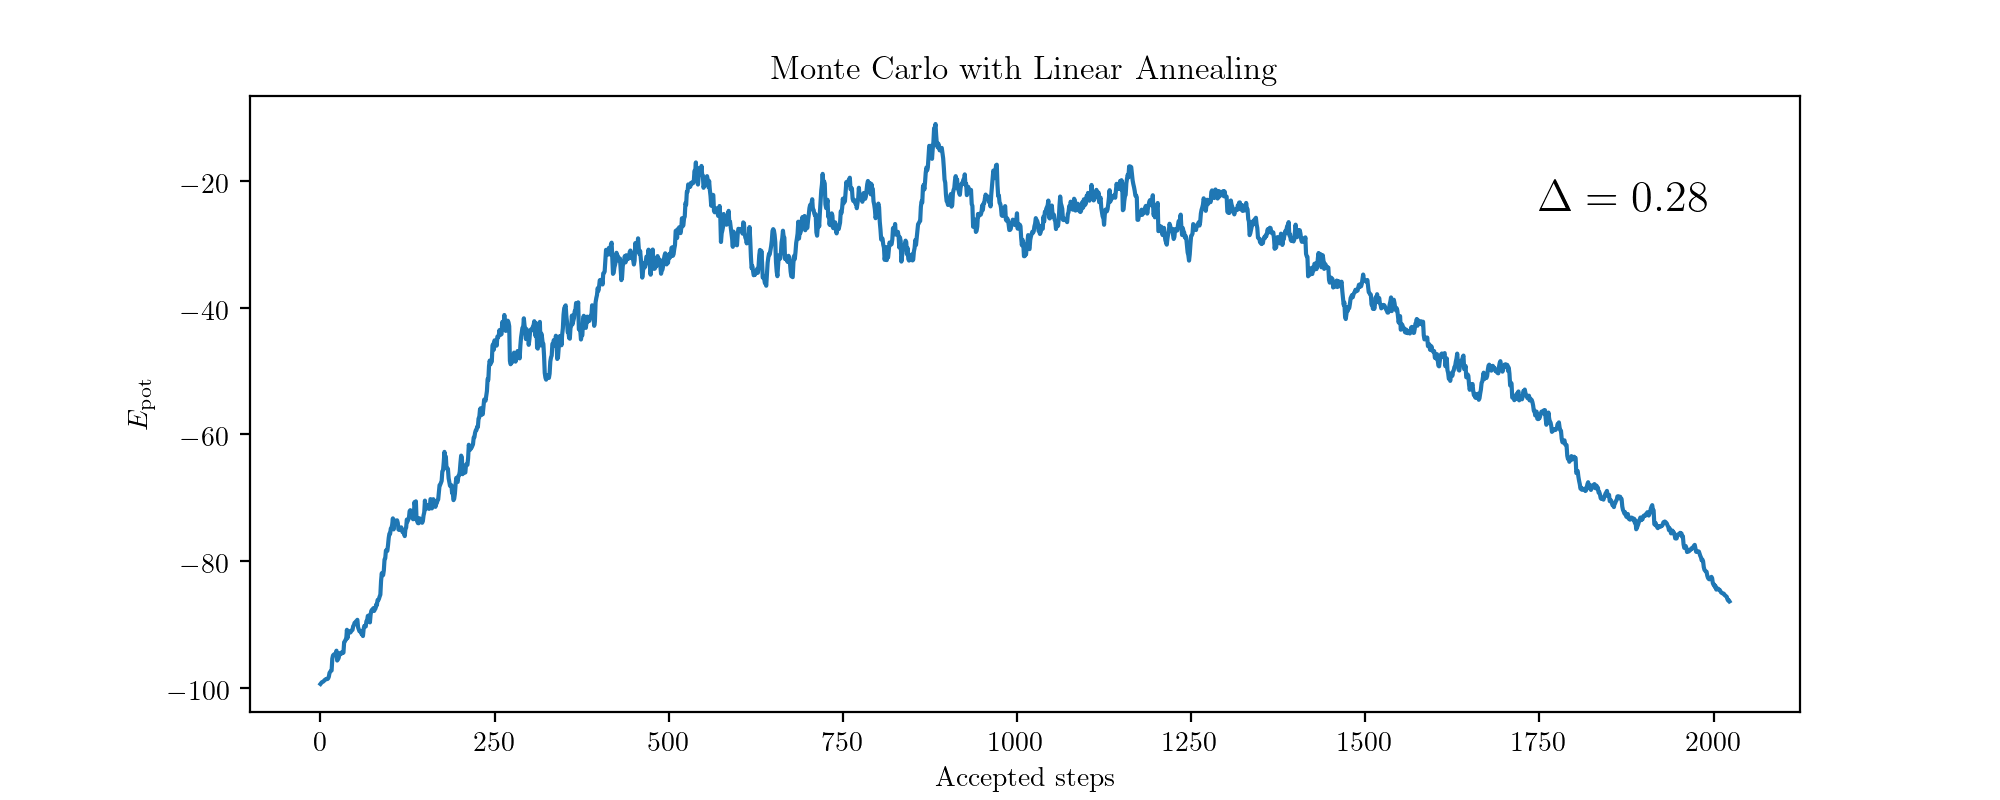

In [231]:
fig, ax = plt.subplots(figsize=(10, 4))
steps = np.arange(e_pot_time_series_MC.shape[0])
ax.plot(steps, e_pot_time_series_MC)

ax.set_title("Monte Carlo with Linear Annealing")
ax.set_ylabel(r"$E_\mathrm{pot}$")
ax.set_xlabel("Accepted steps")
ax.text(1750, -25, r'$\Delta = 0.28$', fontsize=16)

plt.show()

In [217]:
print("Initial potential energy = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[0]))
print("Final potential energy   = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[-1]))

Initial potential energy = -99.3385 (units of epsilon)
Final potential energy   = -92.8738 (units of epsilon)


For this (short) simulation, we see that the initial energy is around $-99 \: \epsilon$, and the final energy is about $-93 \: \epsilon$. From this experiment, we see that the simulated annealing has the ability to lower the crystal's energy back down after its been heated up, since the energies at the start and end are on the same order. We also see based on the gradient of the potential energy near the end of the simulation that if we run the MC for a bit longer, the energy will probably decrease further.

## 4.2

Now we'll try varying the annealing schedule to see if we can achieve an even lower minimum. Let's first try an exponential annealing scheme, whereby we set $k_B T (t+1) = \alpha k_B T (t)$, where $\alpha$ is some value slightly less than 1 i.e. $\alpha = 0.998$. 

I've also written a vectorized function to calculate the energy change due to the displacement of an atom in the MC loop. The speed up using this function is considerable, meaning that we can run our MC simulation for much longer to see if we can lower the potential energy with more steps.

In [465]:
a = (2**(2.0/3.0)) * 1.1 # Increase by 10%
r_c = 1.3
N = 3
L = 3
M = 3
num_steps = 20000
delta = 0.175 # Tune this to give ~50% rejection rate

# Annealing schedule initialization
kb_T_i = 2.0
alpha  = 0.9998 # Exponential annealing parameter
powers = np.arange(num_steps)
annealing_schedule = kb_T_i * np.power(alpha*np.ones(num_steps), powers)

e_pot_time_series_MC, rejection_ratio = MC_MD_loop_fast(N, L, M, a, r_c, delta=delta, 
                                                        num_steps=num_steps, annealing_schedule=annealing_schedule)

print("N, L, M = {}".format(N))
print("Delta = {}, rejection ratio = {:.4f}, total accepted steps = {}.".format(delta, 
                                                                               rejection_ratio, 
                                                                               e_pot_time_series_MC.shape[0]))

# Clip the simulation's first 500 iterations, corresponding to the equilibrium period.
num_steps_to_eq = 500 # Can tweak this based on the plot below
e_pot_time_series_MC_eq = e_pot_time_series_MC[num_steps_to_eq:]

100%|██████████| 20000/20000 [00:07<00:00, 2692.72it/s]

N, L, M = 3
Delta = 0.175, rejection ratio = 0.5161, total accepted steps = 9677.


<IPython.core.display.Javascript object>


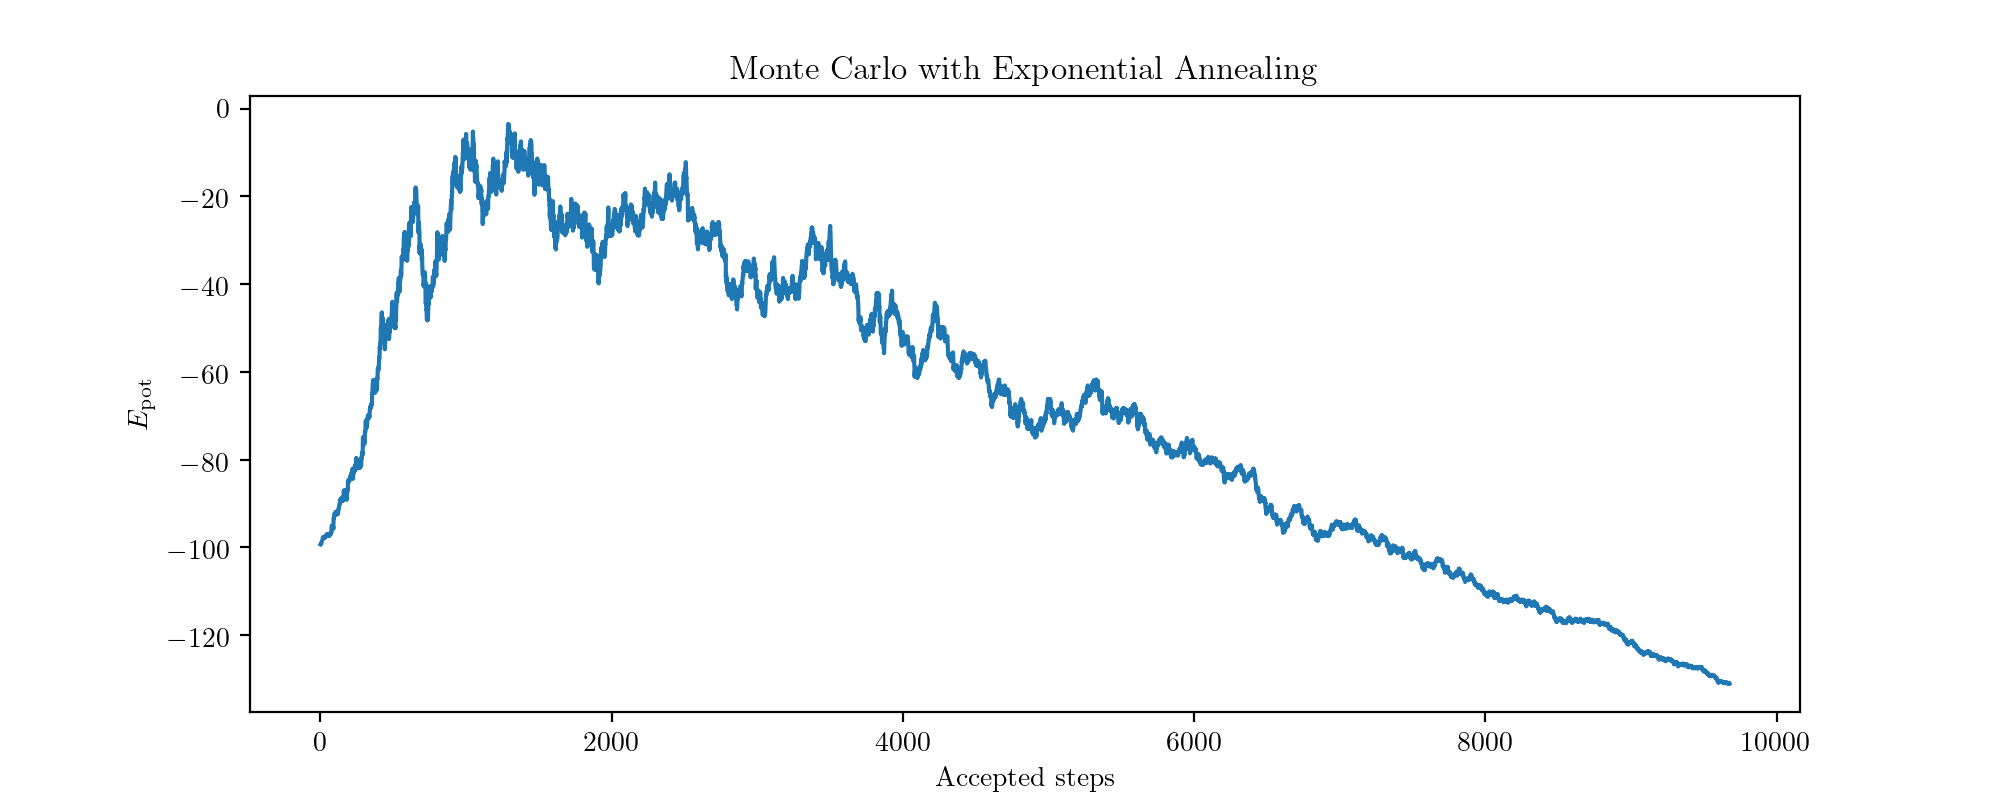

In [466]:
fig, ax = plt.subplots(figsize=(10, 4))
steps = np.arange(e_pot_time_series_MC.shape[0])
ax.plot(steps, e_pot_time_series_MC)

ax.set_title("Monte Carlo with Exponential Annealing")
ax.set_ylabel(r"$E_\mathrm{pot}$")
ax.set_xlabel("Accepted steps")

plt.show()

In [467]:
print("Initial potential energy = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[0]))
print("Final potential energy   = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[-1]))

Initial potential energy = -99.3385 (units of epsilon)
Final potential energy   = -131.0721 (units of epsilon)


<IPython.core.display.Javascript object>


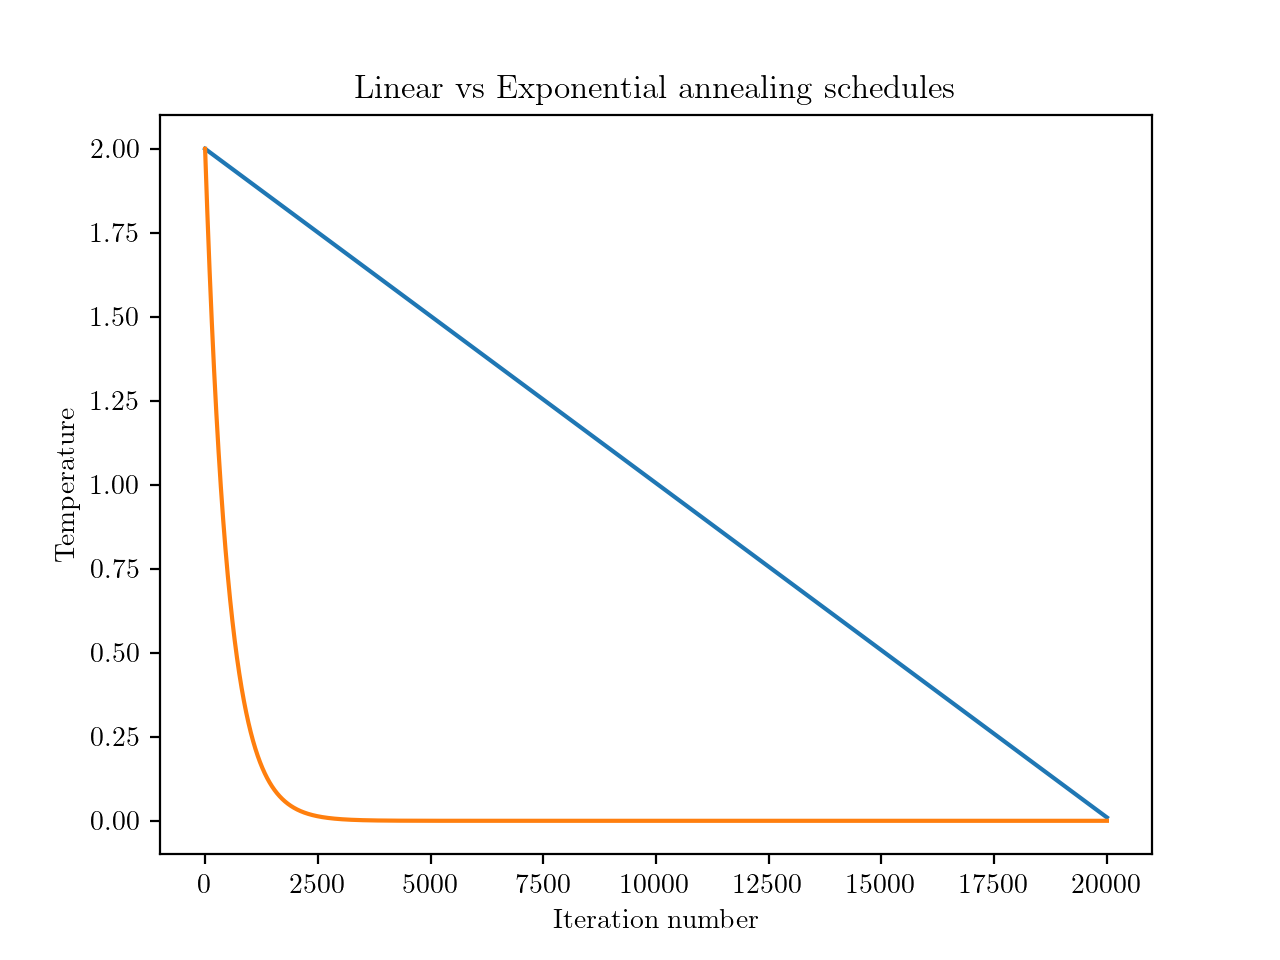

In [470]:
kb_T_i = 2.0
kb_T_f = 1e-2 # Avoid divide by zero and/or overflow in np.exp() errors
annealing_schedule_linear = np.linspace(kb_T_i, kb_T_f, num_steps) # Linear ramp down

alpha  = 0.998 # Exponential annealing parameter
powers = np.arange(num_steps)
annealing_schedule_exp = kb_T_i * np.power(alpha*np.ones(num_steps), powers)

fig, ax = plt.subplots()
ax.plot(np.arange(num_steps), annealing_schedule_linear)
ax.plot(np.arange(num_steps), annealing_schedule_exp)
ax.set_ylabel('Temperature')
ax.set_xlabel('Iteration number')
ax.set_title('Linear vs Exponential annealing schedules')

plt.show()

So we see that the exponential annealing schedule for the temperature, along with a larger number of iterations, gives us a lower final potential energy than the linear annealing case ($-131.0721 \: \epsilon$ versus $-92.8738 \: \epsilon$). 

## 4.3 (optional)

## 4.4

In [471]:
a = (2**(2.0/3.0)) * 1.1 # Increase by 10%
r_c = 1.3
N = 3
L = 3
M = 3
num_steps = 20000
delta = 0.175 # Tune this to give ~50% rejection rate

# Annealing schedule initialization
kb_T_i = 2.0
alpha  = 0.9998 # Exponential annealing parameter
powers = np.arange(num_steps)
annealing_schedule = kb_T_i * np.power(alpha*np.ones(num_steps), powers)

e_pot_time_series_MC, rejection_ratio, pos_time_series = MC_MD_loop_fast(N, L, M, a, r_c, 
                                                                         delta=delta,
                                                                         num_steps=num_steps,
                                                                         annealing_schedule=annealing_schedule,
                                                                         return_pos_time_series=True)

print("N, L, M = {}".format(N))
print("Delta = {}, rejection ratio = {:.4f}, total accepted steps = {}.".format(delta, 
                                                                               rejection_ratio, 
                                                                               e_pot_time_series_MC.shape[0]))

100%|██████████| 20000/20000 [01:58<00:00, 169.10it/s]

N, L, M = 3
Delta = 0.175, rejection ratio = 0.5196, total accepted steps = 9607.


<IPython.core.display.Javascript object>


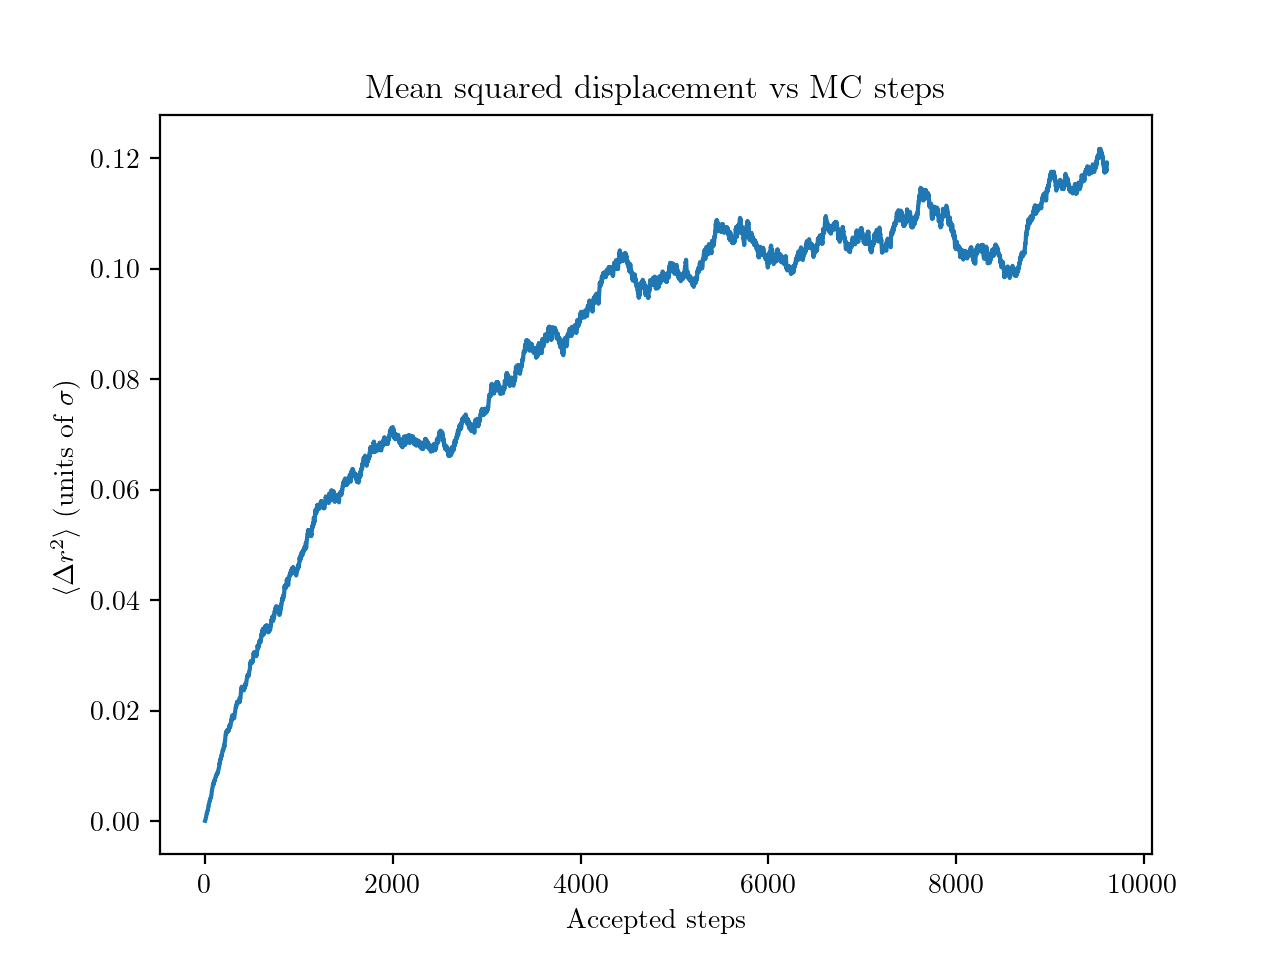

In [473]:
mean_sqr_disp = mean_squared_displacement(pos_time_series)

fig, ax = plt.subplots()
ax.plot(np.arange(mean_sqr_disp.shape[0]), mean_sqr_disp)
ax.set_xlabel("Accepted steps")
ax.set_ylabel(r"$\langle \Delta r^2 \rangle$ (units of $\sigma$)")
ax.set_title("Mean squared displacement vs MC steps")
plt.show()

We see that the mean squared displacement of the atoms is growing even as the temperature goes to zero due to the simulated annealing. This tells us that the atoms have escaped from their initial, local potential wells and have found paths to new minima. This is encouraging because it confirms that the atoms are rearranging themselves to find new structures with lower energy.

## 4.5

In [415]:
a = (2**(2.0/3.0)) * 1.1 # Increase by 10%
r_c = 3.4 # Increase r_cutoff so we can directly compare our minimum to the results in the linked paper
N = 2
L = 2
M = 2
num_steps = 100000
delta = 0.0725    # Tune this to give ~50% rejection rate

# Annealing schedule initialization
kb_T_i = 0.2
alpha  = 0.99998  # Exponential annealing parameter
powers = np.arange(num_steps)
annealing_schedule = kb_T_i * np.power(alpha*np.ones(num_steps), powers)

e_pot_time_series_MC, rejection_ratio = MC_MD_loop_fast(N, L, M, a, r_c, delta=delta, 
                                                        num_steps=num_steps, annealing_schedule=annealing_schedule, 
                                                        latvec_double=True, return_step_sequence=False)

print("N, L, M = {}".format(N))
print("Delta = {}, rejection ratio = {:.4f}, total accepted steps = {}.".format(delta, 
                                                                               rejection_ratio, 
                                                                               e_pot_time_series_MC.shape[0]))

100%|██████████| 100000/100000 [00:30<00:00, 3269.13it/s]

N, L, M = 2
Delta = 0.0725, rejection ratio = 0.4439, total accepted steps = 55614.


<IPython.core.display.Javascript object>


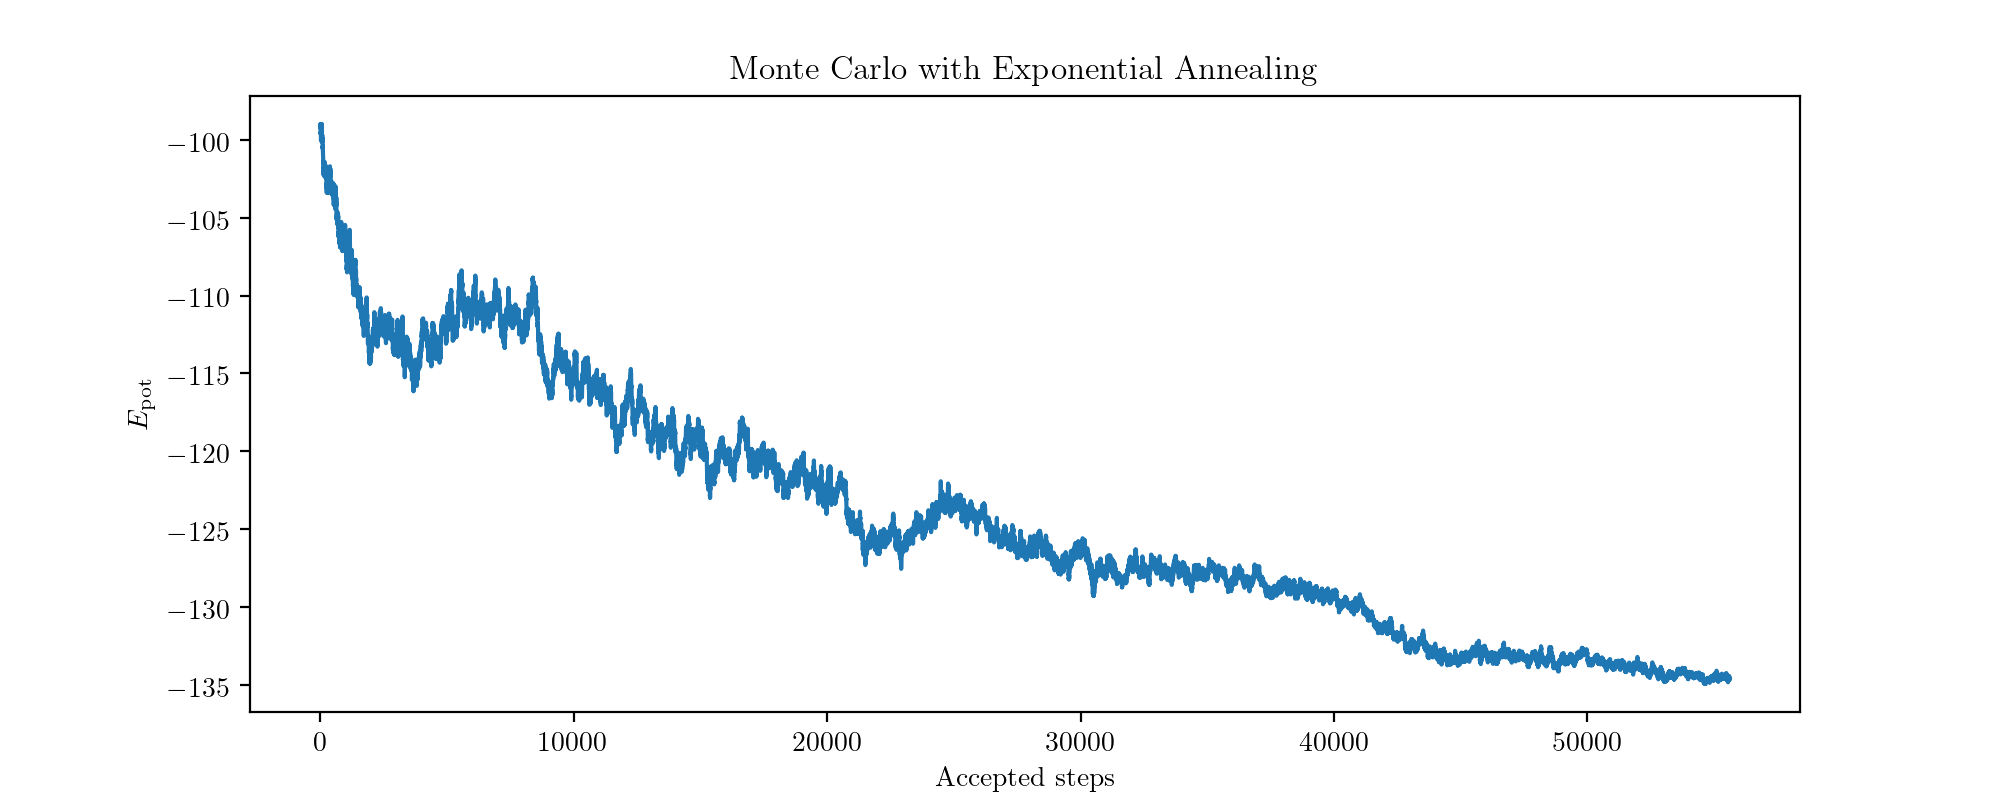

In [416]:
fig, ax = plt.subplots(figsize=(10, 4))
steps = np.arange(e_pot_time_series_MC.shape[0])
ax.plot(steps, e_pot_time_series_MC)

ax.set_title("Monte Carlo with Exponential Annealing")
ax.set_ylabel(r"$E_\mathrm{pot}$")
ax.set_xlabel("Accepted steps")

plt.show()

In [417]:
print("Initial potential energy = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[0]))
print("Final potential energy   = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[-1]))

Initial potential energy = -99.1083 (units of epsilon)
Final potential energy   = -134.6237 (units of epsilon)


For num_atoms = 32, minimum potential energy reported in J. Phys. Chem. A 101, 5111 (1997): $-139.635524 \: \epsilon$. We see that with exponential annealing, a large number of MC iterations (100,000 total iterations, i.e. ~50,000 accepted steps), an increase in the lattice vector sizes (to minimize boundary condition effects), and an increased cutoff radius, we **achieve a final potential energy of about $-134.6 \: \epsilon$**. 

To get even closer to the target value, we could try to add **dynamic control to our step size** ($\Delta$), since the optimal step size should change as the annealing schedule progresses. We could also experiment with **burn-in** time before starting the annealing schedule. This would allow the crystal more time to move about while still warm. This might have a noticeable effect, especially because the exponential annealing is so strong.

# 5. LJ Anneal-Fest 2019

In [498]:
a = (2**(2.0/3.0)) * 1.1 # Increase by 10%
r_c = 3.4 # Increase r_cutoff so we can directly compare our minimum to the results in the linked paper
N = 2
L = 2
M = 2
num_steps = 100000
delta = 0.05    # Tune this to give ~50% rejection rate

# Annealing schedule initialization
kb_T_i = 0.2
alpha  = 0.99991  # Exponential annealing parameter
burn_in = 2000    # Take this many steps before begining anneal schedule
powers = np.arange(num_steps - burn_in)
annealing_schedule = kb_T_i * np.power(alpha*np.ones(num_steps - burn_in), powers)

# Only start annealing after some burn in time
annealing_schedule = np.insert(annealing_schedule, 0, kb_T_i * np.ones(burn_in))

e_pot_time_series_MC, rejection_ratio = MC_MD_loop_fast(N, L, M, a, r_c, delta=delta, 
                                                        num_steps=num_steps, annealing_schedule=annealing_schedule, 
                                                        latvec_double=True, return_step_sequence=False)

print("N, L, M = {}".format(N))
print("Delta = {}, rejection ratio = {:.4f}, total accepted steps = {}.".format(delta, 
                                                                               rejection_ratio, 
                                                                               e_pot_time_series_MC.shape[0]))

100%|██████████| 100000/100000 [00:31<00:00, 3208.53it/s]

N, L, M = 2
Delta = 0.05, rejection ratio = 0.7497, total accepted steps = 25035.


<IPython.core.display.Javascript object>


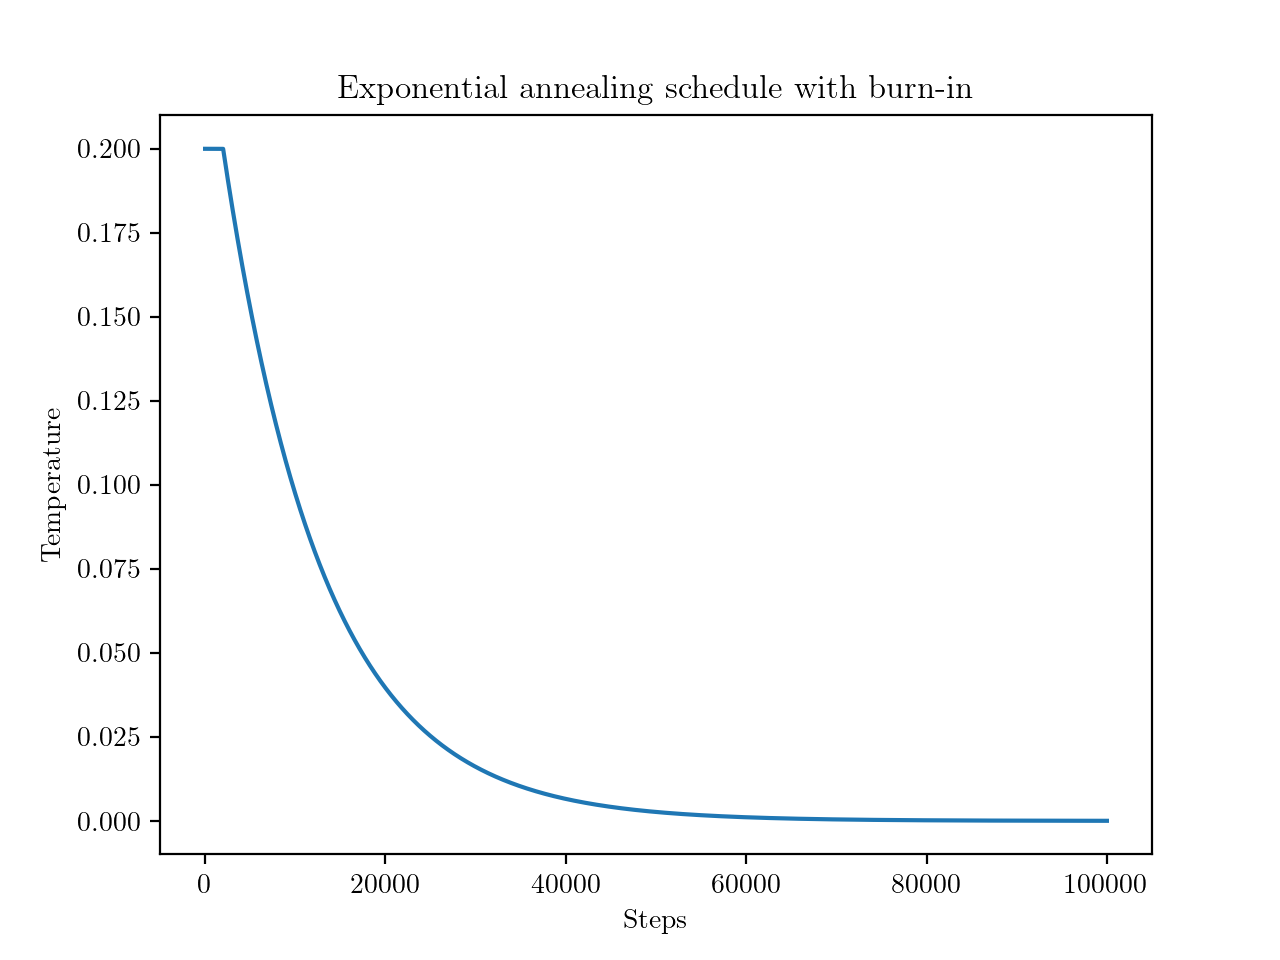

In [499]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_steps), annealing_schedule)
ax.set_ylabel('Temperature')
ax.set_xlabel('Steps')
ax.set_title("Exponential annealing schedule with burn-in")
plt.show()

<IPython.core.display.Javascript object>


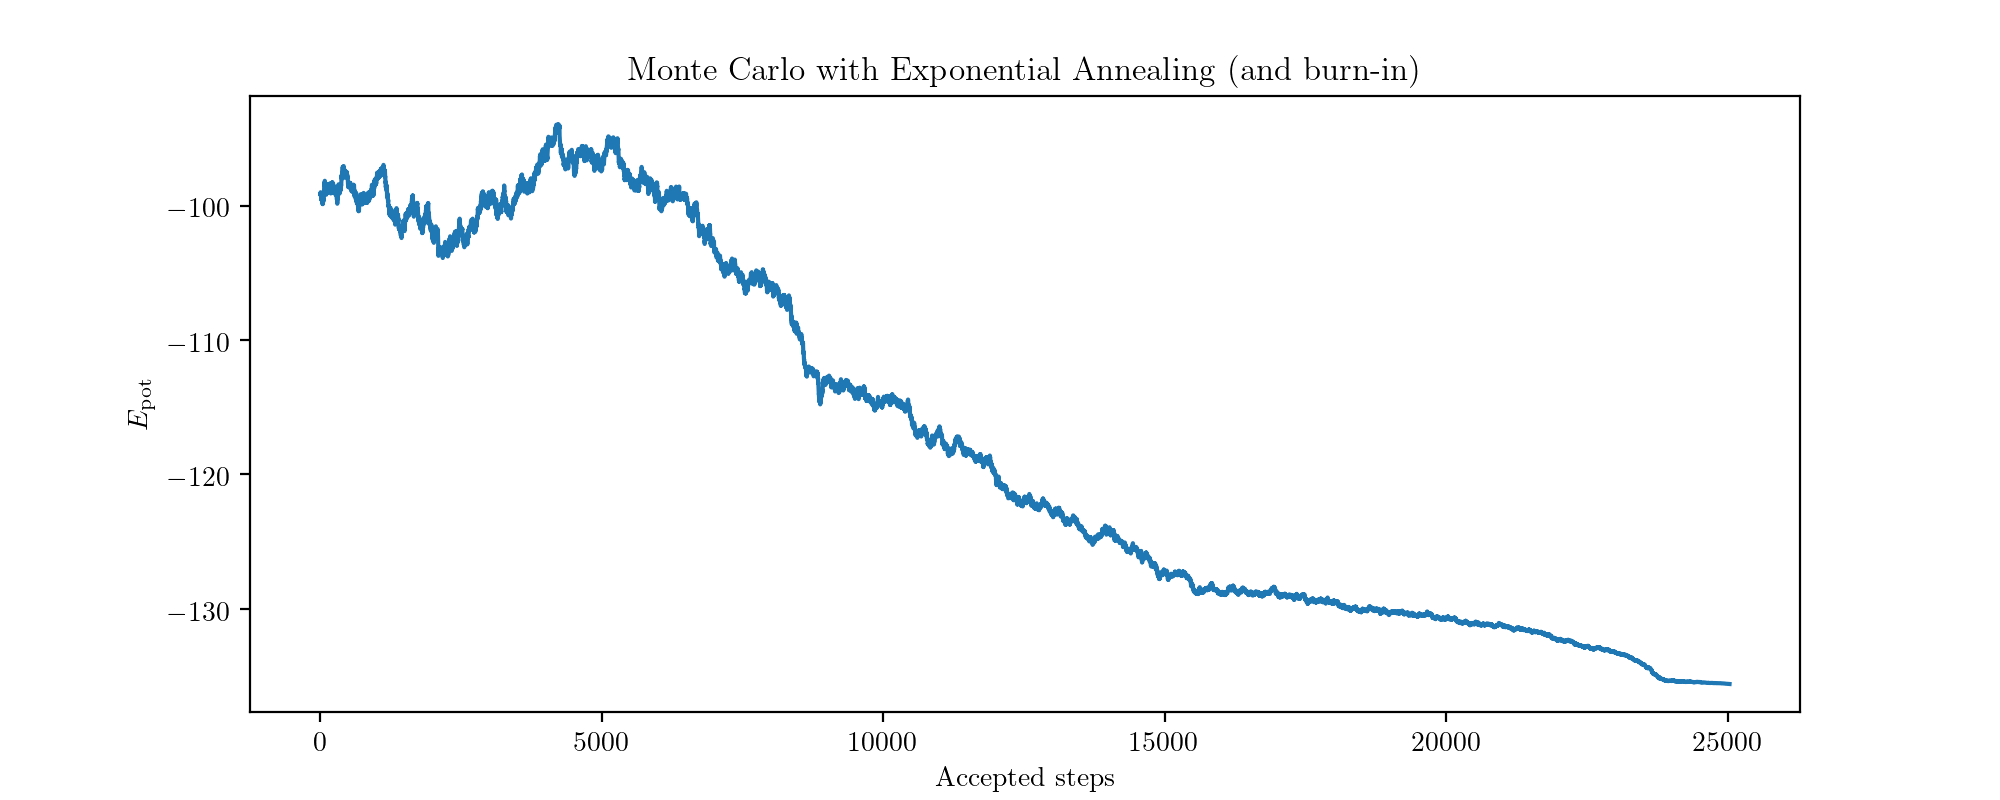

In [502]:
fig, ax = plt.subplots(figsize=(10, 4))
steps = np.arange(e_pot_time_series_MC.shape[0])
ax.plot(steps, e_pot_time_series_MC)

ax.set_title("Monte Carlo with Exponential Annealing (and burn-in)")
ax.set_ylabel(r"$E_\mathrm{pot}$")
ax.set_xlabel("Accepted steps")

plt.show()

In [501]:
print("Initial potential energy = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[0]))
print("Final potential energy   = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[-1]))

Initial potential energy = -99.1083 (units of epsilon)
Final potential energy   = -135.5864 (units of epsilon)


So we see that using the exponential annealing schedule with a short burn-in, and by further tuning step size and the exponential annealing parameter, $\alpha$, we achieve a minimum potential energy of $-135.5864 \: \epsilon$. 

Now, we'll try to use some dynamic control for the step size, $\Delta$, to see if that helps at all, rather than tuning it by hand.

In [506]:
# Import a PID controller
from simple_pid import PID # (PID = Proportional, Integral, Derivative)

Let's create another copy of the MC_MD_loop_fast() function with the PID controller on $\Delta$. Let's also strip away the excess return items (like pos_time_series) to get it as fast as possible.

In [568]:
def MC_MD_loop_fast_PID(N, L, M, a, r_c, kb_T=0.1, delta=0.1, num_steps=10000, 
                        annealing_schedule=None, latvec_double=True, PID_burn_in=1, return_final_pos=False):
    '''
    Another version of the MC_MD_loop_fast() function, but with PID control on delta this time.
    
    This MC function makes use of the vectorized delta_energy_single_atom_disp(), which calculates the change in 
    the potential energy of the crystal due to the shift of a single atom without using any loops.
    
    This version is pretty fast, giving us about 3000 iterations/second.
    
    Annealing schedule should be np.array() of length num_steps if not None.
    '''
    
    # Initialization
    atoms_t, latvec_mat = setup_cell(L, M, N, a=a)
    
    # Problem 4.5
    if latvec_double:
        latvec_mat *= 2
    
    num_atoms, dimensions = atoms_t.shape
    e_pot_t, foo = calc_energy_and_forces(atoms_t, latvec_mat, r_c, calc_forces=False)
    
    # Number of accepted steps
    num_accepted = 0
    
    # Will return a time series of the potential energies. 
    # Right off the bat, we don't know how long the "time series" will be depending on how many steps we reject
    e_pot_time_series = []
    e_pot_time_series.append(e_pot_t)
    
    delta_time_series = []
    delta_time_series.append(delta)
    
    # If no annealing, the temperature is just constant throughout the simulation.
    if annealing_schedule is None:
        annealing_schedule = kb_T * np.ones(num_steps)
        
    # Create a PID object for the step size (delta)
    # From simple-pid documentation:
    # class simple_pid.PID.PID(Kp=1.0, Ki=0.0, Kd=0.0, setpoint=0, sample_time=0.01, 
    #       output_limits=(None, None), auto_mode=True, proportional_on_measurement=False)
    # Target is 0.5 rejection rate
    # Kp, Ki, Kd are all hyperparameters that can be tuned.
    pid_delta = PID(0.1, 0.01, 0.005, setpoint=0.5, sample_time=0.5)
    
    for i in tqdm(range(num_steps)):
        
        # Pick an atom randomly
        j = np.random.randint(num_atoms)
        atoms_j_old = np.copy(atoms_t[j])
        
        # Generate random displacement
        delta_r = np.random.rand(dimensions)
        disp_vec = delta * (delta_r - 0.5)
        disp_vec_norm = np.linalg.norm(disp_vec) / (np.sqrt(dimensions) * delta)
        atoms_t[j] += disp_vec
        
        # Calculate the new energy of the crystal
        e_delta = delta_energy_single_atom_disp(atoms_t, latvec_mat, r_c, j, disp_vec)
        e_pot_t_plus_1 = e_pot_t + e_delta
        
        kb_T = annealing_schedule[i]
        boltzmann_factor = np.exp(-1* (1/(kb_T)) * (e_pot_t_plus_1 - e_pot_t))
        
        # PID control on delta for rejection ratio
        if i >= PID_burn_in:
            reject_ratio_curr = (i - len(e_pot_time_series))/i
            delta = pid_delta(reject_ratio_curr)
            
        if e_pot_t_plus_1 < e_pot_t or disp_vec_norm < boltzmann_factor:
            e_pot_time_series.append(e_pot_t_plus_1)
            e_pot_t = e_pot_t_plus_1
            
            delta_time_series.append(delta)
        else:
            # Reject the step and return to old state
            atoms_t[j] = atoms_j_old
    
    reject_ratio = (num_steps - len(e_pot_time_series)) / num_steps
    
    if return_final_pos:
        return np.array(e_pot_time_series), reject_ratio, delta_time_series, atoms_t
    
    return np.array(e_pot_time_series), reject_ratio, delta_time_series

In [570]:
a = (2**(2.0/3.0)) * 1.1 # Increase by 10%
r_c = 3.4 # Increase r_cutoff so we can directly compare our minimum to the results in the linked paper
N = 2
L = 2
M = 2
num_steps = 100000
delta = 0.1    # Tune this to give ~50% rejection rate

# Annealing schedule initialization
kb_T_i = 0.2
alpha  = 0.99991  # Exponential annealing parameter
burn_in = 2000    # Take this many steps before begining anneal schedule
powers = np.arange(num_steps - burn_in)
annealing_schedule = kb_T_i * np.power(alpha*np.ones(num_steps - burn_in), powers)

# Only start annealing after some burn in time
annealing_schedule = np.insert(annealing_schedule, 0, kb_T_i * np.ones(burn_in))

e_pot_time_series_MC, rejection_ratio, delta_time_series, atoms_final = MC_MD_loop_fast_PID(N, L, M, a, r_c, 
                                                                               delta=delta,num_steps=num_steps, 
                                                                               annealing_schedule=annealing_schedule, 
                                                                               PID_burn_in=500, return_final_pos=True)

print("N, L, M = {}".format(N))
print("Initial delta = {}, final rejection rate = {:.4f}, total accepted steps = {}."\
      .format(delta,rejection_ratio,e_pot_time_series_MC.shape[0]))

100%|██████████| 100000/100000 [00:38<00:00, 2615.14it/s]

N, L, M = 2
Initial delta = 0.1, final rejection rate = 0.6502, total accepted steps = 34976.


<IPython.core.display.Javascript object>


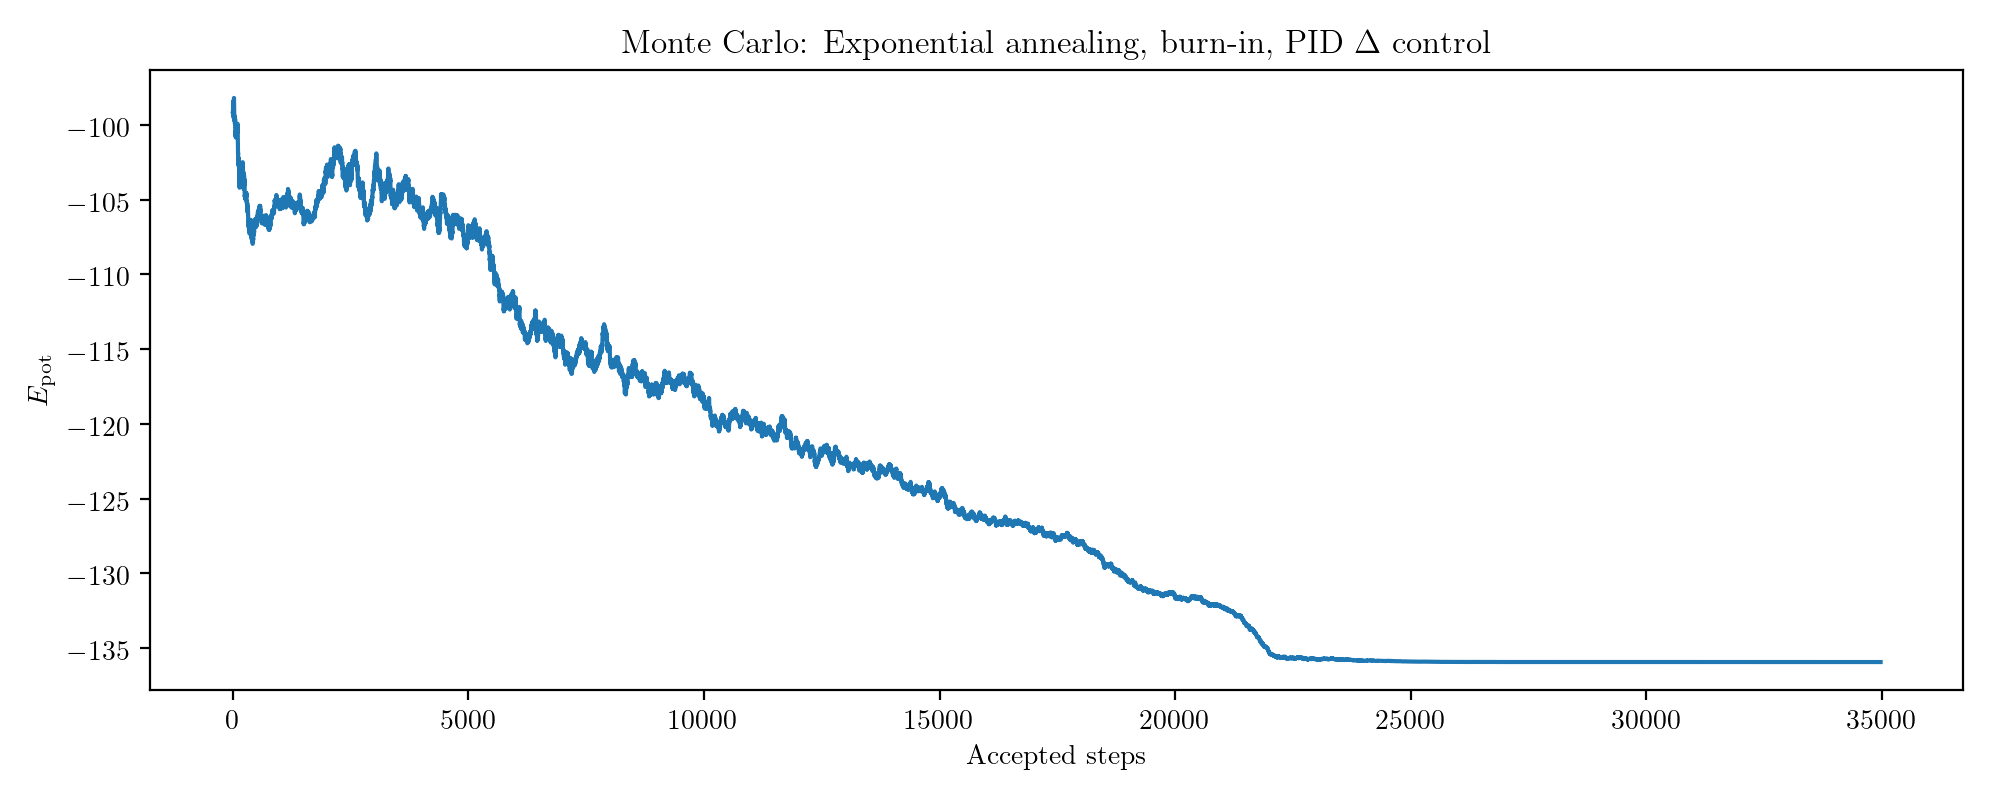

In [579]:
fig, ax = plt.subplots(figsize=(10, 4))
steps = np.arange(e_pot_time_series_MC.shape[0])
ax.plot(steps, e_pot_time_series_MC)

ax.set_title(r"Monte Carlo: Exponential annealing, burn-in, PID $\Delta$ control")
ax.set_ylabel(r"$E_\mathrm{pot}$")
ax.set_xlabel("Accepted steps")
fig.tight_layout()
plt.show()

In [572]:
print("Initial potential energy = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[0]))
print("Final potential energy   = {:.4f} (units of epsilon)".format(e_pot_time_series_MC[-1]))

Initial potential energy = -99.1083 (units of epsilon)
Final potential energy   = -135.9262 (units of epsilon)


<IPython.core.display.Javascript object>


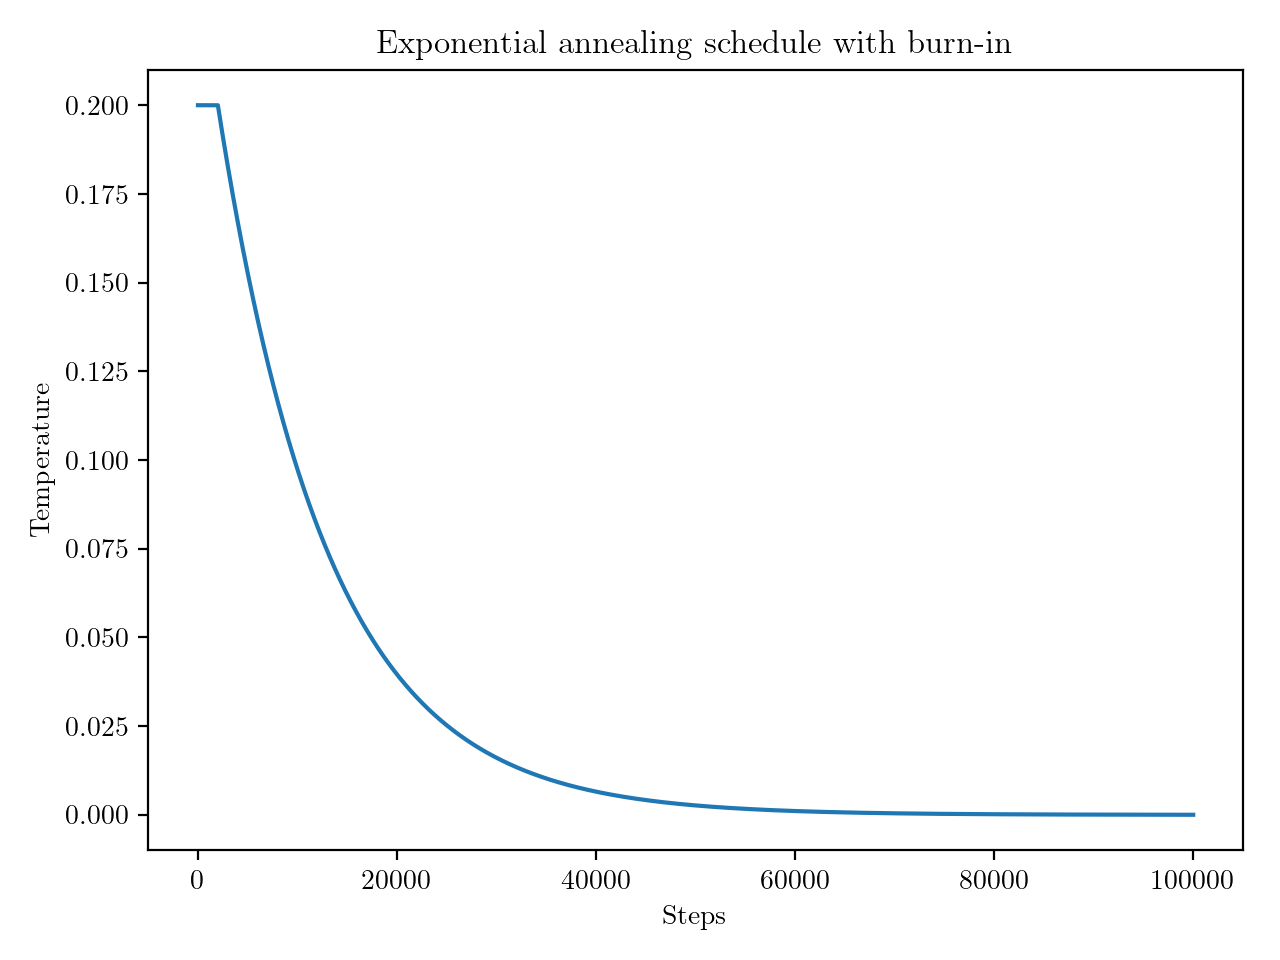

In [580]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_steps), annealing_schedule)
ax.set_ylabel('Temperature')
ax.set_xlabel('Steps')
ax.set_title("Exponential annealing schedule with burn-in")
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


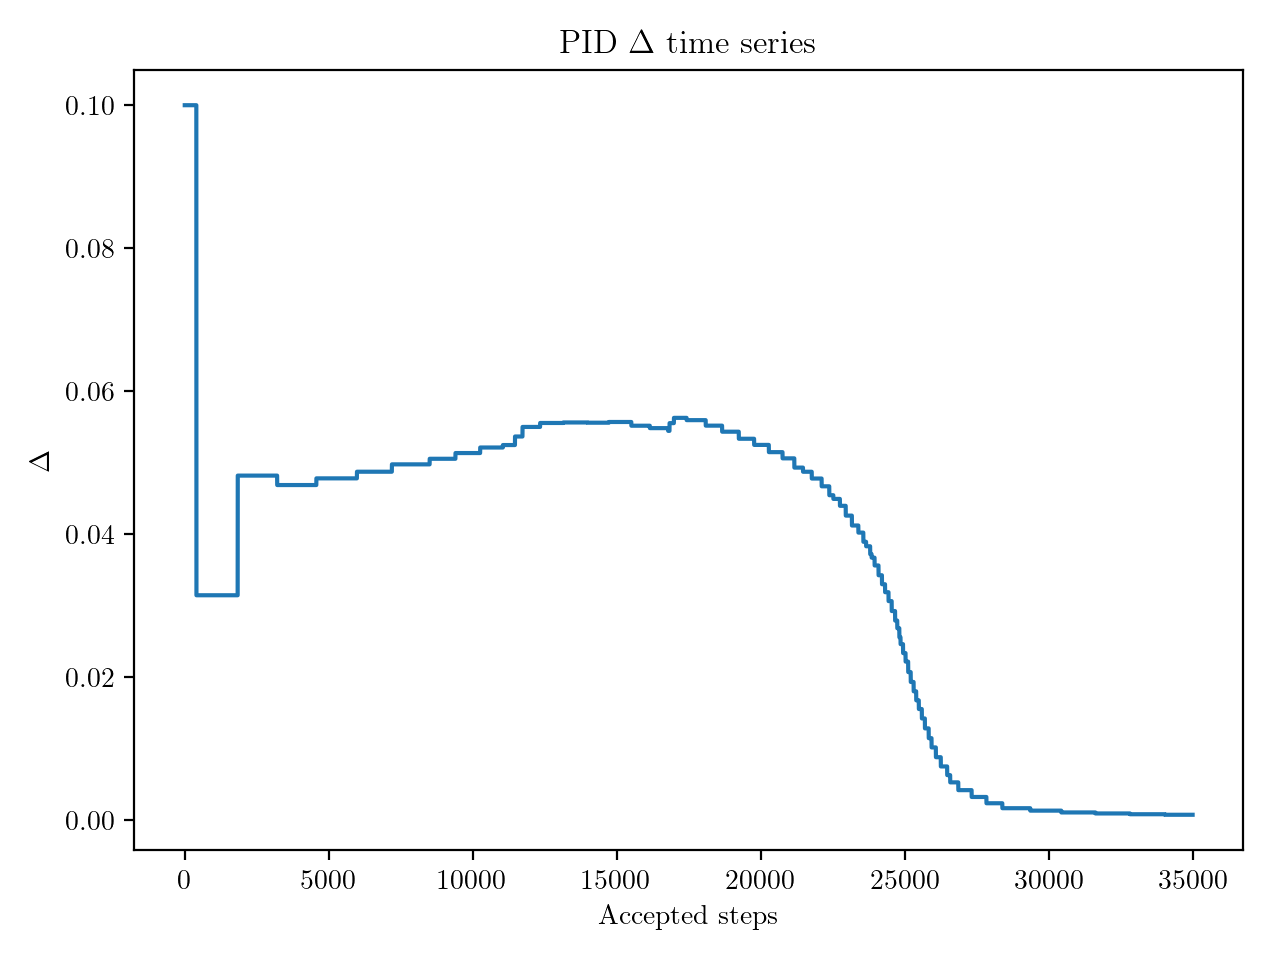

In [581]:
fig, ax = plt.subplots()
ax.plot(steps, delta_time_series)
ax.set_title(r"PID $\Delta$ time series")
ax.set_ylabel(r"$\Delta$")
ax.set_xlabel("Accepted steps")
fig.tight_layout()
plt.show()

Note: the discontinuities in the plot of $\Delta$ above are due to the different burn-in times expiring: 500 steps for the PID burn-in and 2000 steps for the annealing schedule burn-in.

**So we find that by using exponential annealing with burn-in, and by using a PID controller (with a short burn-in itself), we can achieve a new minimum of the potential energy of** $$E_\mathrm{pot,\: f} = -135.9262 \: \epsilon.$$ By further tuning the many hyperparameters of our new model, we could probably push this potential energy floor even lower.

**Visualize the final nanoparticle:**

<IPython.core.display.Javascript object>


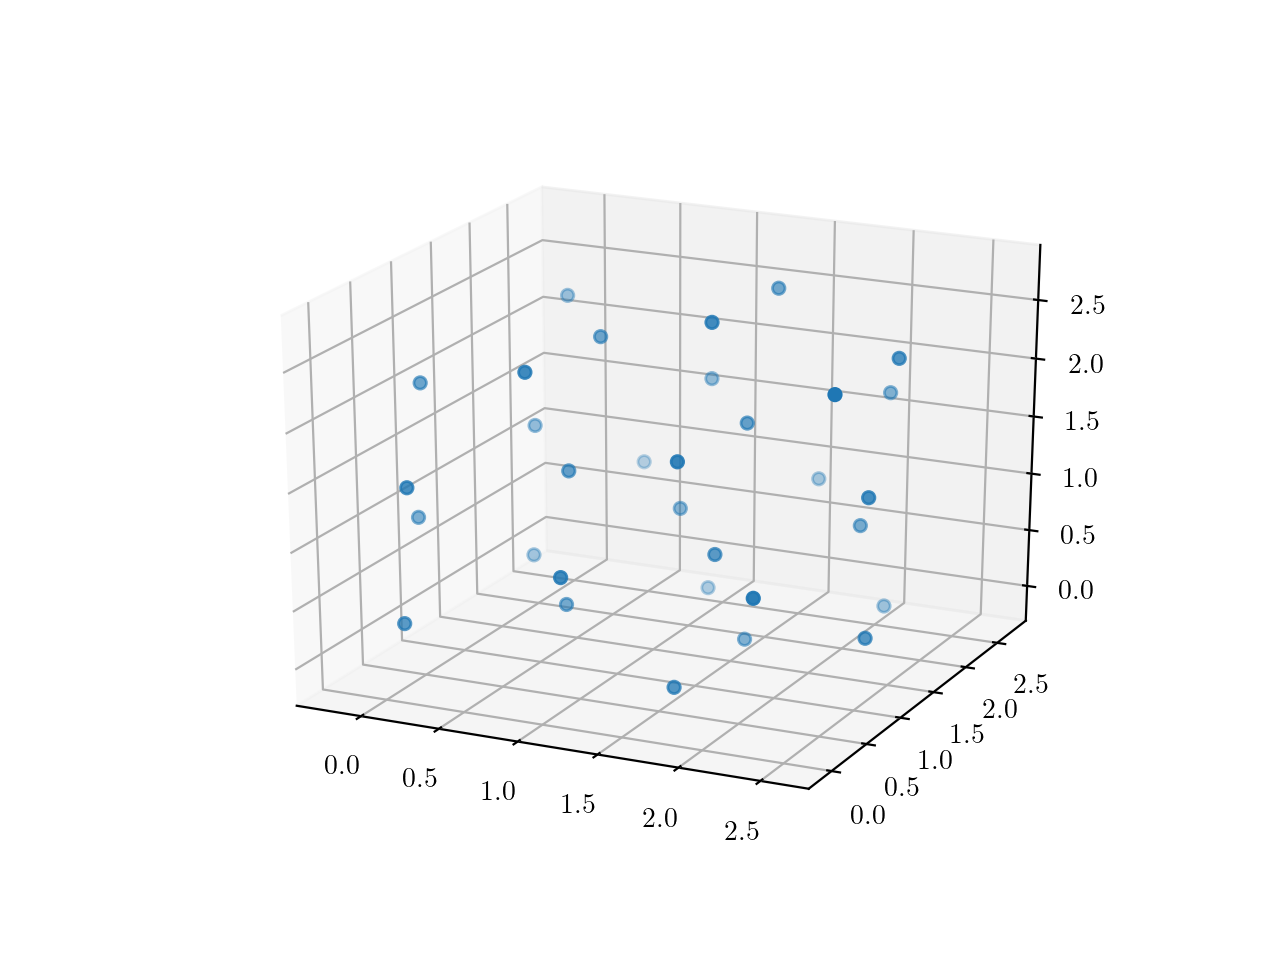

In [576]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(atoms_final[:, 0], atoms_final[:, 1], atoms_final[:, 2])
plt.show()

**Compared to the original lattice:**

<IPython.core.display.Javascript object>


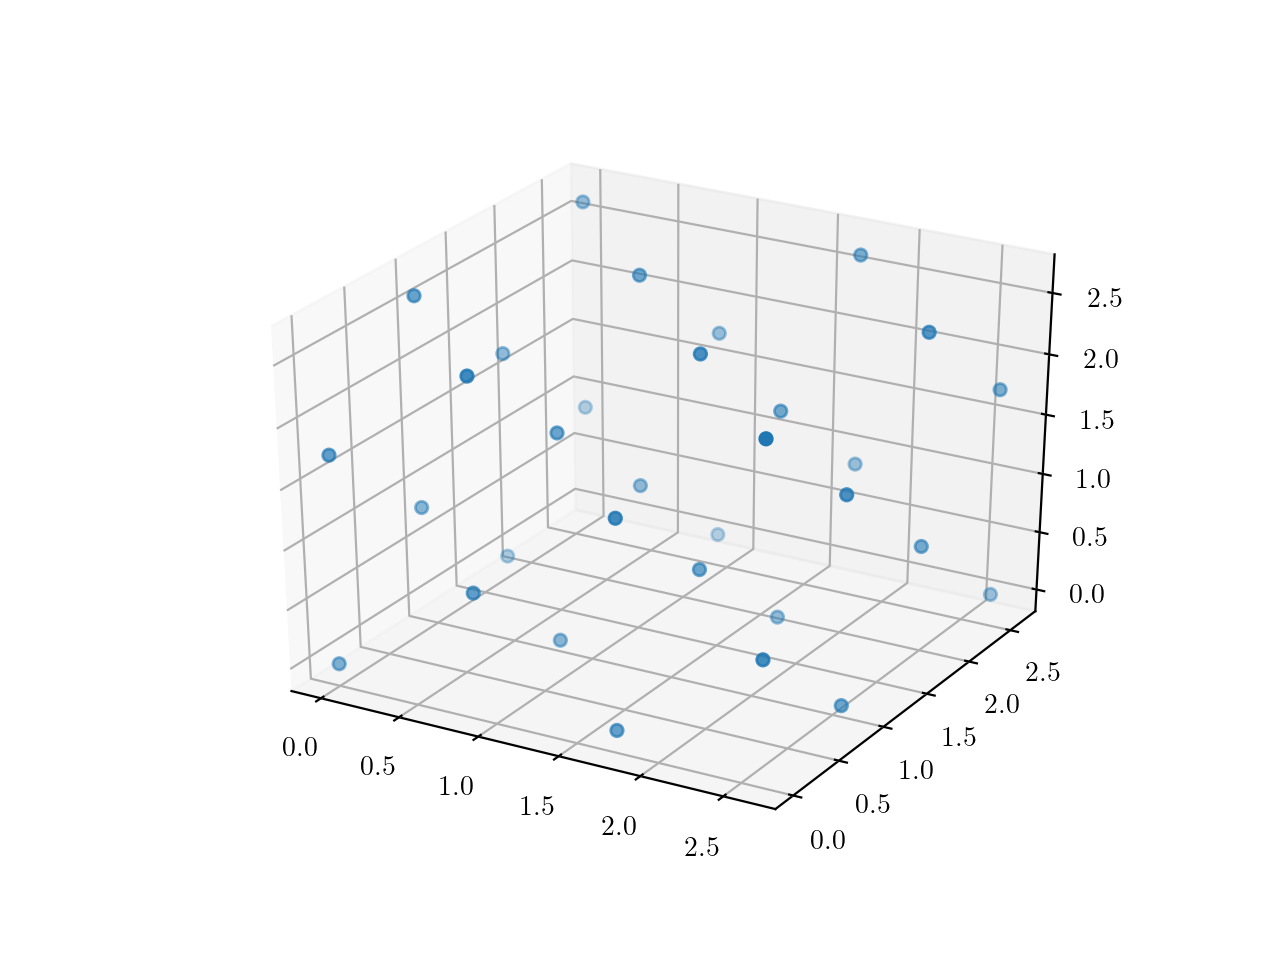

In [578]:
atoms_init, latvec_mat = setup_cell(2, 2, 2, a = 2**(2/3) * 1.1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(atoms_init[:, 0], atoms_init[:, 1], atoms_init[:, 2])
plt.show()